In [1]:
library(readr)
library(dplyr)
library(UpSetR)
library(ggplot2)
library(Seurat)
library(ggpubr)
library(scales)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




# Figure 1

In [2]:
consensus.count.matrix <- read.table('./GiRAFR_outputs/inhouse/consensus.count.matrix', header = T)
colnames(consensus.count.matrix)[1] <- 'gRNA'
rownames(consensus.count.matrix) <- consensus.count.matrix$gRNA
consensus.count.matrix <- consensus.count.matrix[,-1]

In [3]:
cells_gRNA_file <- './GiRAFR_outputs/inhouse/cells.gRNA.txt'
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                         header = FALSE, fill = TRUE, stringsAsFactors = FALSE, 
                         col.names=1:n_col)
colnames(cells.gRNA)[1:7]=c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = max(feature_order))



In [4]:
all.matrix <- Read10X('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/filtered_feature_bc_matrix/')
gRNA.seurat = CreateSeuratObject(counts = all.matrix$`CRISPR Guide Capture`)

10X data contains more than one type and is being returned as a list containing matrices of each type.

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [5]:
protospacer_calls_per_cell <- read.csv('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/crispr_analysis/protospacer_calls_per_cell.csv', stringsAsFactors = FALSE)

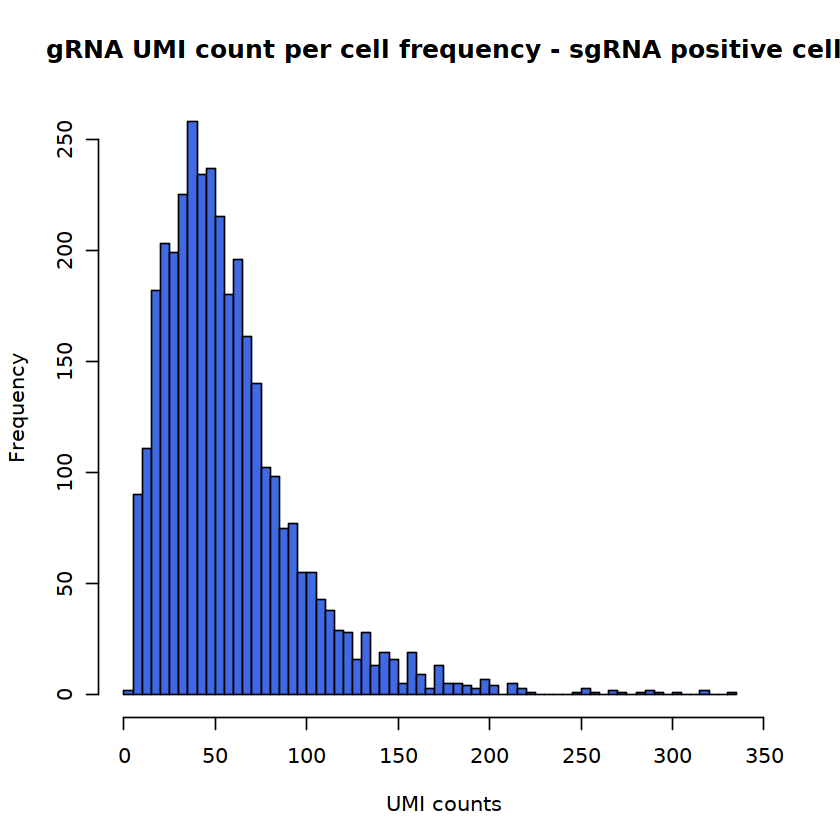

In [6]:
#pdf('Figure2_gRNA_UMI_histogram.pdf', width = 8, height = 8)
hist(gRNA.seurat$nCount_RNA[protospacer_calls_per_cell$cell_barcode], breaks = 100, xlim = c(0,350),xlab = 'UMI counts',
    main = 'gRNA UMI count per cell frequency - sgRNA positive cell', col = 'royalblue')
#dev.off()

# puromycin expression

In [7]:
expression.matrix.cropseq3 <- Read10X('/staging/leuven/stg_00064/projects/cropseq/267genes/develop/public_data/exp2_deep/exp2_deep_cropseq3_expression/outs/filtered_feature_bc_matrix')
cropseeq3.seurat = CreateSeuratObject(counts = expression.matrix.cropseq3)
cropseeq3.seurat

An object of class Seurat 
33539 features across 5747 samples within 1 assay 
Active assay: RNA (33539 features, 0 variable features)
 2 layers present: counts, data

In [8]:
cropseeq3.seurat <- NormalizeData(object = cropseeq3.seurat, normalization.method = "LogNormalize", scale.factor = 10000)


In [9]:
protospacer_calls_per_cell <- 
read.csv('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/crispr_analysis/protospacer_calls_per_cell.csv', stringsAsFactors = FALSE)
cells.gRNA <- read.table('/staging/leuven/stg_00064/projects/cropseq/267genes/develop/paper/exp2_deep/re-run/cells.gRNA.txt', 
                         header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:8)                   
colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = max(feature_order))

cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = grepl('variant', MT)) %>% summarise(has_MT=any(is_MT))
# if cell has multiple guides, one guide is variant, is_MT is still TRUE

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.


In [10]:
pipeline_NotEmpty <- cells.num_features$cb
#length(pipeline_NotEmpty)
pipeline_Single <- cells.num_features$cb[which(cells.num_features$num_features == 1)]

cellranger_NotEmpty <- protospacer_calls_per_cell$cell_barcode
#length(cellranger_NotEmpty)


In [11]:
cropseeq3.seurat@meta.data$cb <- rownames(cropseeq3.seurat@meta.data)

cropseeq3.seurat@meta.data <- merge(cropseeq3.seurat@meta.data, 
      protospacer_calls_per_cell, by.x = 'cb', by.y = 'cell_barcode', all.x = TRUE)
cropseeq3.seurat@meta.data$num_features[is.na(cropseeq3.seurat@meta.data$num_features)] <- 0
cropseeq3.seurat@meta.data <- merge(cropseeq3.seurat@meta.data, 
      cells.num_features, by = 'cb', all.x = TRUE)
cropseeq3.seurat@meta.data$num_features.y[is.na(cropseeq3.seurat@meta.data$num_features.y)] <- 0

In [12]:
table(cropseeq3.seurat$num_features.x)


   0    1    2    3    4 
2320 3165  250    7    5 

In [13]:
#pdf('Figure1_puromycin_expression.pdf', width = 6, height = 8)

# cropseeq3.seurat@meta.data$num_features.x <- 
# factor(cropseeq3.seurat@meta.data$num_features.x, levels = c('0','1','2','3','4'))
# VlnPlot(cropseeq3.seurat, features = 'cropseq3', group.by  = 'num_features.x',pt.size = 0,
#         cols = c('grey30','navy','royalblue','orange','brown'))+
# xlab('Number of gRNAs (Cell Ranger)')+theme_classic()+
# theme(panel.border =element_rect(colour = 'black', fill = NA, size = 1), 
#       axis.line=element_blank(), 
#       axis.title.x = element_text(size = 14, family = 'Helvetica Neue'),
#       axis.text.x = element_text(size = 12, family = 'Helvetica Neue'),
#       axis.text.y = element_text(size = 12, family = 'Helvetica Neue'),
#       axis.title.y = element_text(size = 14,family = 'Helvetica Neue'))+
# stat_summary(fun.y = median, geom='point', size = 20, colour = "black", shape = 95)+NoLegend()
#dev.off()

# Figure S1g

In [14]:
all.matrix <- Read10X('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/filtered_feature_bc_matrix/')
CRISPR.matrix <- all.matrix$`CRISPR Guide Capture`
rm(all.matrix)
consensus.count.matrix <- read.table('./GiRAFR_outputs/inhouse/consensus.count.matrix', header = TRUE, row.names = 1)
colnames(consensus.count.matrix) <- paste0(colnames(consensus.count.matrix),'-1')
consensus.count.matrix.WT <- consensus.count.matrix[!grepl("variant", rownames(consensus.count.matrix)),]
rownames(consensus.count.matrix.WT) <- sub('_gene','',rownames(consensus.count.matrix.WT))


10X data contains more than one type and is being returned as a list containing matrices of each type.



In [15]:
consensus.count.matrix_all_UMI <- read.table('../../exp2_deep/lower_threshold/consensus.count.matrix', header = TRUE, row.names = 1)
colnames(consensus.count.matrix_all_UMI) <- paste0(colnames(consensus.count.matrix_all_UMI),'-1')

consensus.count.matrix_all_UMI.WT <- consensus.count.matrix_all_UMI[!grepl("variant", rownames(consensus.count.matrix_all_UMI)),]
rownames(consensus.count.matrix_all_UMI.WT) <- sub('_gene','',rownames(consensus.count.matrix_all_UMI.WT))


In [16]:
nrow(consensus.count.matrix_all_UMI.WT)

[1] 113

In [17]:
dim(CRISPR.matrix)
dim(consensus.count.matrix)
dim(consensus.count.matrix_all_UMI)

[1]  120 5744

[1] 1997 5359

[1] 16269  5558

In [18]:
table(colSums(CRISPR.matrix > 0))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 278  837 1061 1095  862  617  400  215  173   93   42   27   22   14    3    1 
  17   18   22 
   1    2    1 

In [19]:
table(colSums(consensus.count.matrix > 0))
5744- sum(table(colSums(consensus.count.matrix > 0)))


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1152 1371 1157  729  461  237  119   67   30   21    8    2    2    1    1    1 

[1] 385

In [20]:
mean(colSums(consensus.count.matrix_all_UMI))
mean(colSums(consensus.count.matrix_all_UMI > 0))
table(colSums(consensus.count.matrix_all_UMI > 0))
5744- sum(table(colSums(consensus.count.matrix_all_UMI > 0)))

[1] 43.47139

[1] 6.994422


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
411 532 544 586 498 508 415 402 350 261 214 159 124 106  85  82  56  39  35  28 
 21  22  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  40  42  98 
 27  20  11   9  17   5   7   2   8   2   1   1   3   1   1   2   2   2   1   1 

[1] 186

Histogram gRNA

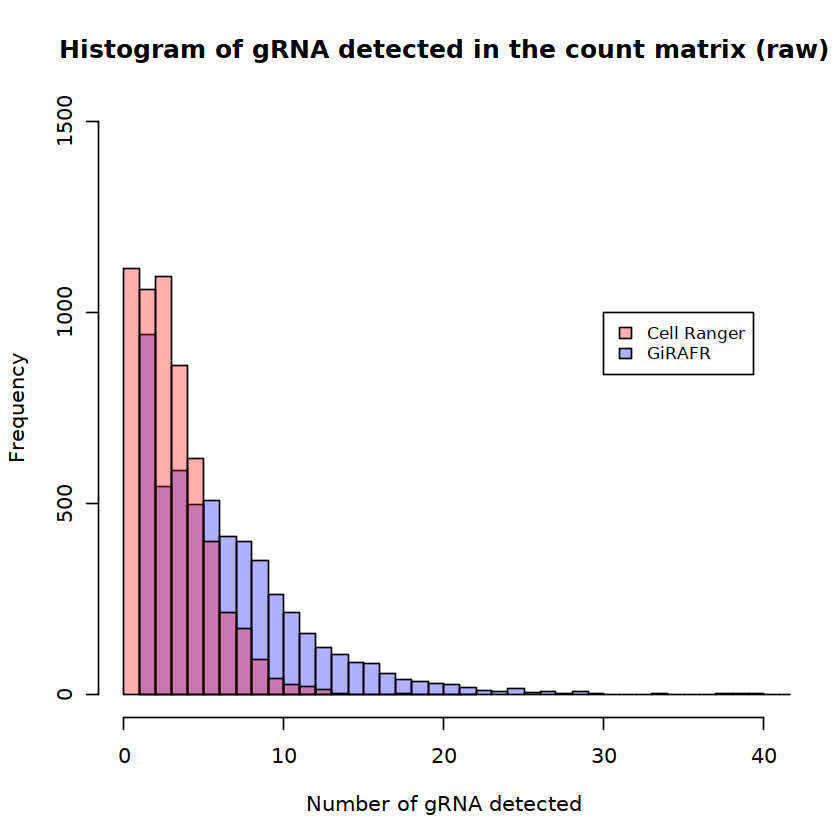

In [21]:
#pdf('Histogram_gRNA_consensus_matrix_all_UMI.pdf')
c1 <- rgb(0,0,255,max = 255, alpha = 80)
c2 <- rgb(255,0,0, max = 255, alpha = 80)
hist(colSums(consensus.count.matrix_all_UMI > 0), main = 'Histogram of gRNA detected in the count matrix (raw)',
     breaks = 100, xlab = 'Number of gRNA detected', col = c1, xlim = c(0,40), ylim = c(0,1500))
hist(colSums(CRISPR.matrix > 0), 
     breaks = 20, xlab = 'Number of gRNA detected', col = c2, add = TRUE)
legend(30, 1000, legend=c("Cell Ranger", "GiRAFR"),
       fill=c(c2 , c1), cex=0.8)
#dev.off()

In [22]:
cellranger.df <- as.data.frame(colSums(CRISPR.matrix > 0))
colnames(cellranger.df) <- 'num_gRNA'
cellranger.df$cb <- rownames(cellranger.df)
pipeline.df <- as.data.frame(colSums(consensus.count.matrix > 0))
colnames(pipeline.df) <- 'num_gRNA'
pipeline.df$cb <- rownames(pipeline.df)

In [23]:
merged.df <- merge(cellranger.df, pipeline.df, by = 'cb', all = TRUE, suffixes = c('.cellranger','.pipeline'))
merged.df$num_gRNA.pipeline[is.na(merged.df$num_gRNA.pipeline)] <- 0

In [24]:
merged.df <- merged.df %>% gather(key = 'method', value = 'num_gRNA', -cb)

In [25]:
merged.df$num_gRNA2 <- ifelse(merged.df$num_gRNA > 10, '>10', merged.df$num_gRNA)

In [26]:
cells_gRNA_file <- 'GiRAFR_outputs/inhouse//cells.gRNA.txt'
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                         header = FALSE, fill = TRUE, stringsAsFactors = FALSE, 
                         col.names=1:n_col)
colnames(cells.gRNA)[1:7]=c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = max(feature_order))

protospacer_calls_per_cell <- 
read.csv('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/crispr_analysis/protospacer_calls_per_cell.csv', stringsAsFactors = FALSE)

In [27]:
table(protospacer_calls_per_cell$num_features)
5744 - sum(table(protospacer_calls_per_cell$num_features))
table(cells.num_features$num_features)
5744 - sum(table(cells.num_features$num_features))



   1    2    3    4 
3165  250    7    5 

[1] 2317


   1    2    3    4 
3593  286   16    4 

[1] 1845

In [28]:
MT_file <- 'GiRAFR_outputs/inhouse/all.MT.txt'
MT <- read.table(MT_file, header = FALSE)
colnames(MT) <- c('gene name','structure','structure length', 'position','mutation','variant number')
Freq.df = as.data.frame(table(MT$`variant number`))
colnames(Freq.df) <- c('Type','Number')
summary(Freq.df$Number)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.947   1.000  11.000 

In [29]:
cells.num_features$cb <- paste0(cells.num_features$cb, '-1')

In [30]:
diff_empty_cells <- cells.num_features$cb[!cells.num_features$cb %in% protospacer_calls_per_cell$cell_barcode]
diff_empty_cells <- cells.gRNA[cells.gRNA$cb %in% diff_empty_cells,]
diff_empty_cells <- merge(diff_empty_cells, Freq.df, by.x = 'MT', by.y = 'Type', all.x = TRUE)

In [31]:
#diff_empty_cells[which(diff_empty_cells$Number == 2),] # filter with certain number of mutation events

# Figure 1g

In [32]:
cells.gRNA.single.MT <- read.table('./GiRAFR_outputs/inhouse/cells.gRNA.single.MT.txt', stringsAsFactors = FALSE)


In [33]:
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('CTRL',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [34]:
all.matrix <- Read10X('/staging/leuven/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/outs/filtered_feature_bc_matrix/')
expression.seurat = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat_ori <- expression.seurat
expression.seurat <- subset(expression.seurat, 
                             cells = cells.gRNA.single.MT$cb)
expression.seurat

10X data contains more than one type and is being returned as a list containing matrices of each type.



An object of class Seurat 
33538 features across 3593 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [35]:
library(ggbeeswarm)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


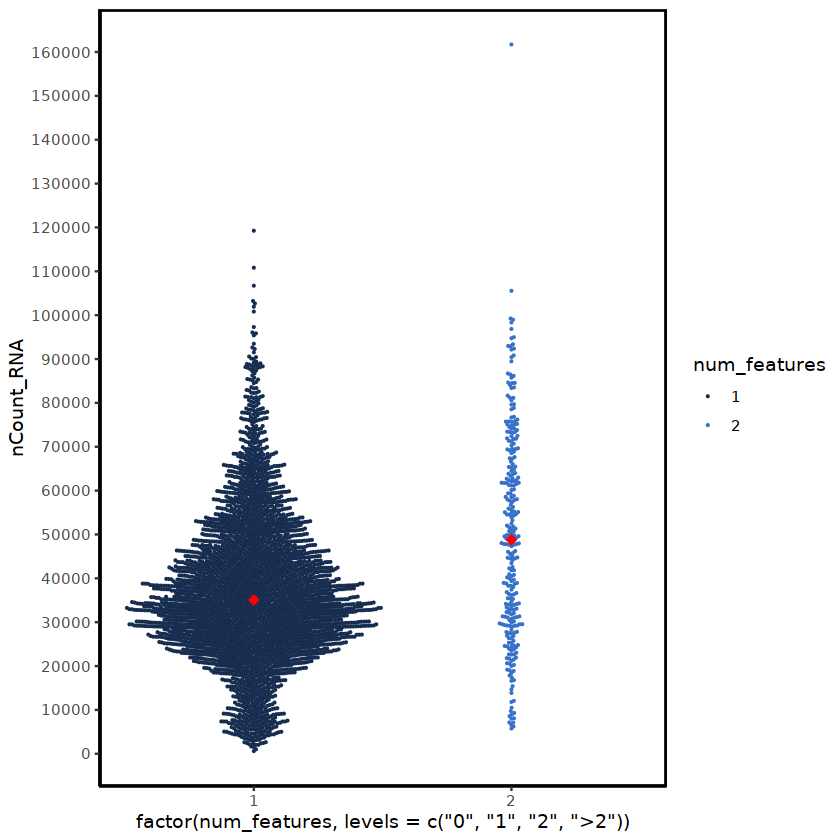

In [36]:
#pdf('nCount_doublets_violin.pdf')
meta.data <- expression.seurat_ori@meta.data
meta.data$cb <- rownames(meta.data)
meta.data <- merge(meta.data, cells.num_features, by = 'cb', all = TRUE)
meta.data$num_features[is.na(meta.data$num_features)] <- 0
meta.data$num_features[which(meta.data$num_features > 2)] <- '>2'


ggplot(meta.data[which(meta.data$num_features %in% c('1','2')),], 
       aes(x= factor(num_features, levels = c('0','1','2','>2')), y=nCount_RNA, color = num_features))+
scale_y_continuous(breaks=seq(0,300000,10000))+
geom_beeswarm(cex = 0.5, size = 0.1)+theme_bw() + 
stat_summary(fun = median, geom="point", col='red', shape=18, size=3)+theme_classic()+
theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
scale_color_manual(breaks = c("1", "2"),
                   values=c("#162d50", "#3771c8"))

#dev.off()

In [37]:
expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)


In [38]:
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

In [39]:
table(expression.seurat@meta.data$is_WT) # cell wiltype vs mutant type


FALSE  TRUE 
 1033  2560 

In [40]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
    KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
    tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
                    data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

    tmp.df$target = gene
    tmp.df$cb = rownames(tmp.df)
    all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

In [41]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

In [42]:
all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df$type_is_WT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$is_WT)

In [43]:
head(all.exp2.MT.df)

,cb,expression,type,target,V4,V5,is_WT,type_is_WT
,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>
1,AAACCCAAGTAGCATA-1,0.2847051,KO,CHEK1,90,None,TRUE,KOTRUE
2,AAACCCATCAAGAGGC-1,0.4517048,KO,EZH2,37,None,TRUE,KOTRUE
3,AAACCCATCCACCTGT-1,0.0000000,Control,CHEK1,52,Rest:1D(1),FALSE,ControlFALSE
4,AAACCCATCCACCTGT-1,3.5903594,Control,RPL18,52,Rest:1D(1),FALSE,ControlFALSE
5,AAACCCATCCACCTGT-1,0.2217178,Control,TDG,52,Rest:1D(1),FALSE,ControlFALSE
6,AAACCCATCCACCTGT-1,0.0000000,Control,UHRF1,52,Rest:1D(1),FALSE,ControlFALSE


In [44]:
all.exp2.MT.df$type_is_WT2 <- all.exp2.MT.df$type_is_WT
all.exp2.MT.df[which(all.exp2.MT.df$type_is_WT == 'ControlFALSE' |
                    all.exp2.MT.df$type_is_WT == 'ControlNA' |
                    all.exp2.MT.df$type_is_WT == 'ControlTRUE'),'type_is_WT2'] <- 'Control'

In [45]:
gRNA_targets <- unique(expression.seurat@meta.data$KO)
#rowSums(expression.seurat@assays$RNA@counts[gRNA_targets[gRNA_targets!='Control'], CTRL_cells] < 1)

In [46]:
gRNA_targets <- unique(expression.seurat@meta.data$KO)
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
#h <- hist(rowSums(expression.seurat@assays$RNA@counts[gRNA_targets[gRNA_targets!='Control'], CTRL_cells] < 1), plot = FALSE,breaks = 100)
#plot(h, xlab = 'Number of cells with counts < 1', main = 'Expression < 1 in control cells')
high_exp_targets <- gRNA_targets[gRNA_targets!='Control'][rowSums(expression.seurat@assays$RNA@counts[gRNA_targets[gRNA_targets!='Control'], 
                                                                                                        CTRL_cells] < 1) <= 400]
high_exp_targets
length(high_exp_targets)

[1] "CHEK1"   "DEK"     "DNMT1"   "ATAD2"   "PCGF5"   "HDAC1"   "TDG"    
 [8] "HDAC2"   "HAT1"    "HELLS"   "SMARCD1" "RPL18"   "TRIM28"  "TRMT112"

[1] 14

In [47]:
high_exp_targets_girafr <- high_exp_targets

In [48]:
length(CTRL_cells)

[1] 757

high expression targets :  0 counts less than 400 cells in control

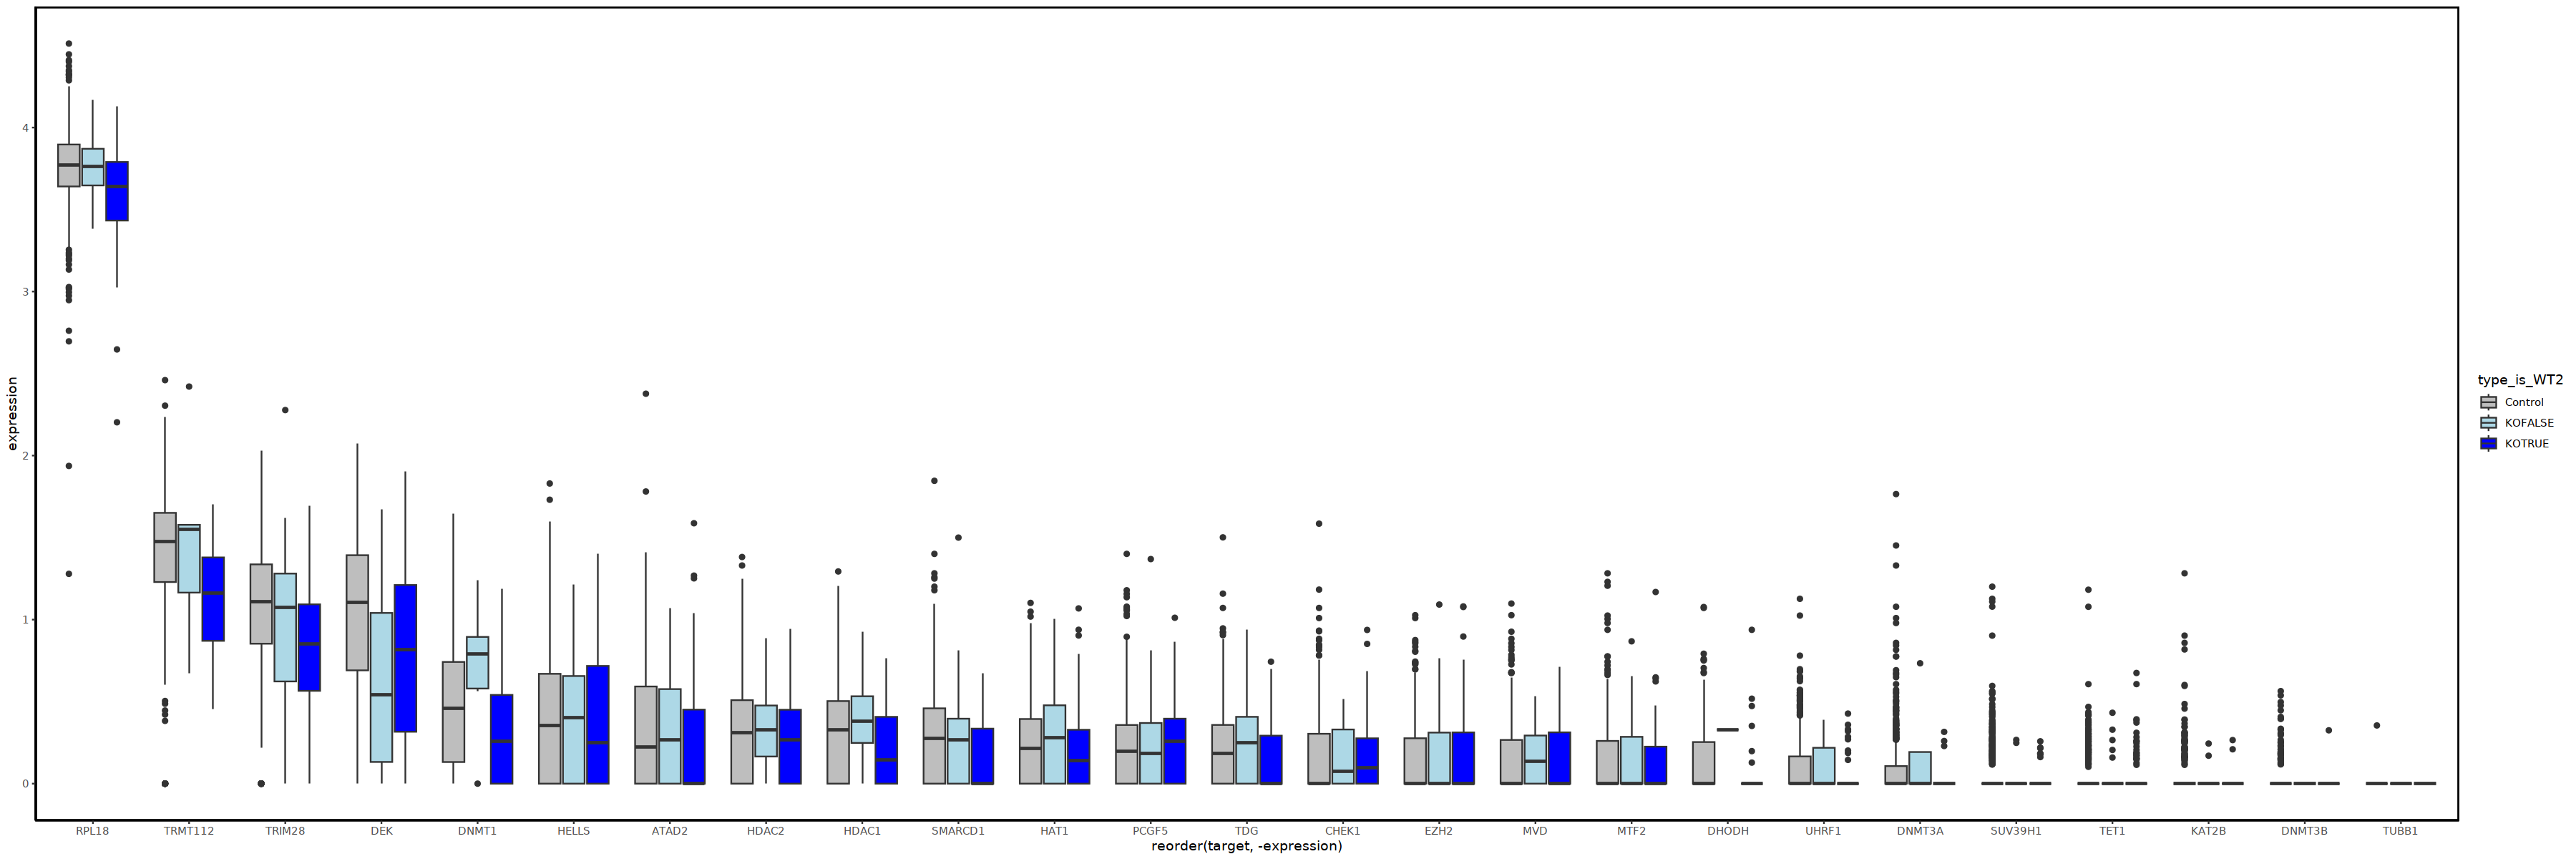

In [49]:
options(repr.plot.width=30,repr.plot.height=10)

ggplot(all.exp2.MT.df, aes(x = reorder(target, -expression), y = expression, fill = type_is_WT2)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"), 
                  values=c("grey", "lightblue",'blue'))+
geom_boxplot()+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


In [50]:
all.exp2.MT.df$MT_gRNA <- ifelse(grepl(pattern = 'gRNA', all.exp2.MT.df$V5), 1,0)
all.exp2.MT.df$MT_U6 <- ifelse(grepl(pattern = 'U6', all.exp2.MT.df$V5), 1,0)
all.exp2.MT.df$MT_Rest <- ifelse(grepl(pattern = 'Rest', all.exp2.MT.df$V5), 1,0)

In [51]:
all.exp2.MT.df$tmp <- paste(all.exp2.MT.df$type_is_WT2, all.exp2.MT.df$MT_gRNA, sep = '_')
all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'Control_0' |
                    all.exp2.MT.df$tmp == 'Control_1'),'tmp'] <- 'Control'
table(all.exp2.MT.df$tmp)


  Control KOFALSE_0 KOFALSE_1  KOTRUE_0 
    18925       380       452      2004 

In [52]:
all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']

# compare to the average expression in control cells

tmp,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,10598,1.0000000,0.8807291,0.008555205
KOFALSE_0,261,0.9095394,0.8279447,0.051248490
KOFALSE_1,271,1.1312500,1.0220928,0.062087715
KOTRUE_0,1123,0.8366918,0.8749148,0.026108138


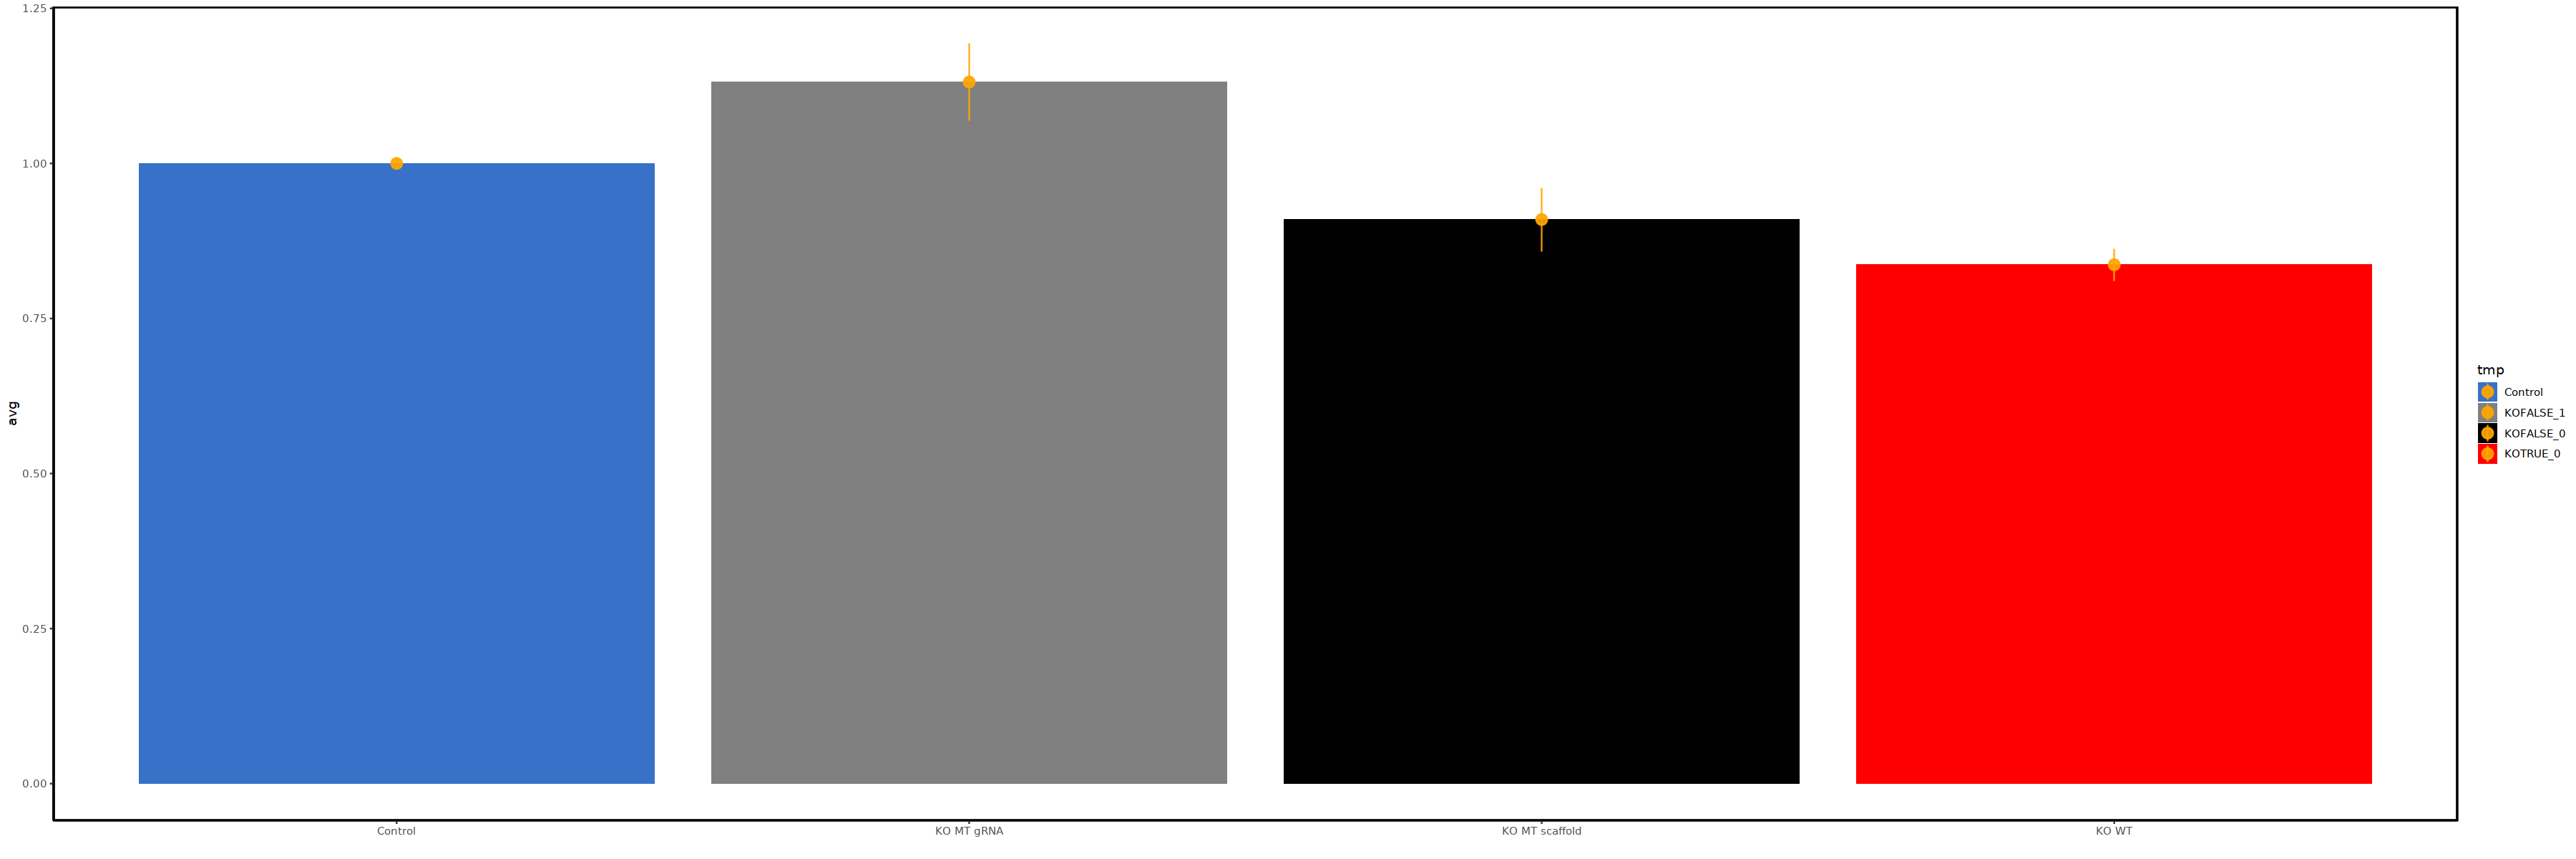

In [53]:
#pdf('Figure2d_high_exp_targets_normalizedbycontrol_barplot.pdf')
tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]
tmp.df <- tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), 
                                               sem = sd(expression_norm)/sqrt(n))


tmp.df
ggplot(tmp.df, 
       aes(
           x = tmp, 
           y = avg, fill = tmp)) + 
geom_col()+
#geom_errorbar(aes(ymin=avg-sd, ymax=avg+sd), width=.2,position=position_dodge(.9)) +
#geom_pointrange(aes(x=nr_mutation, y=avg, ymin=avg-sd, ymax=avg+sd), colour="orange", alpha=0.9, size=1.3)+
geom_pointrange(aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                   values=c("#3771c8", "#808080",'#000000','#ff0000'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))
#dev.off()

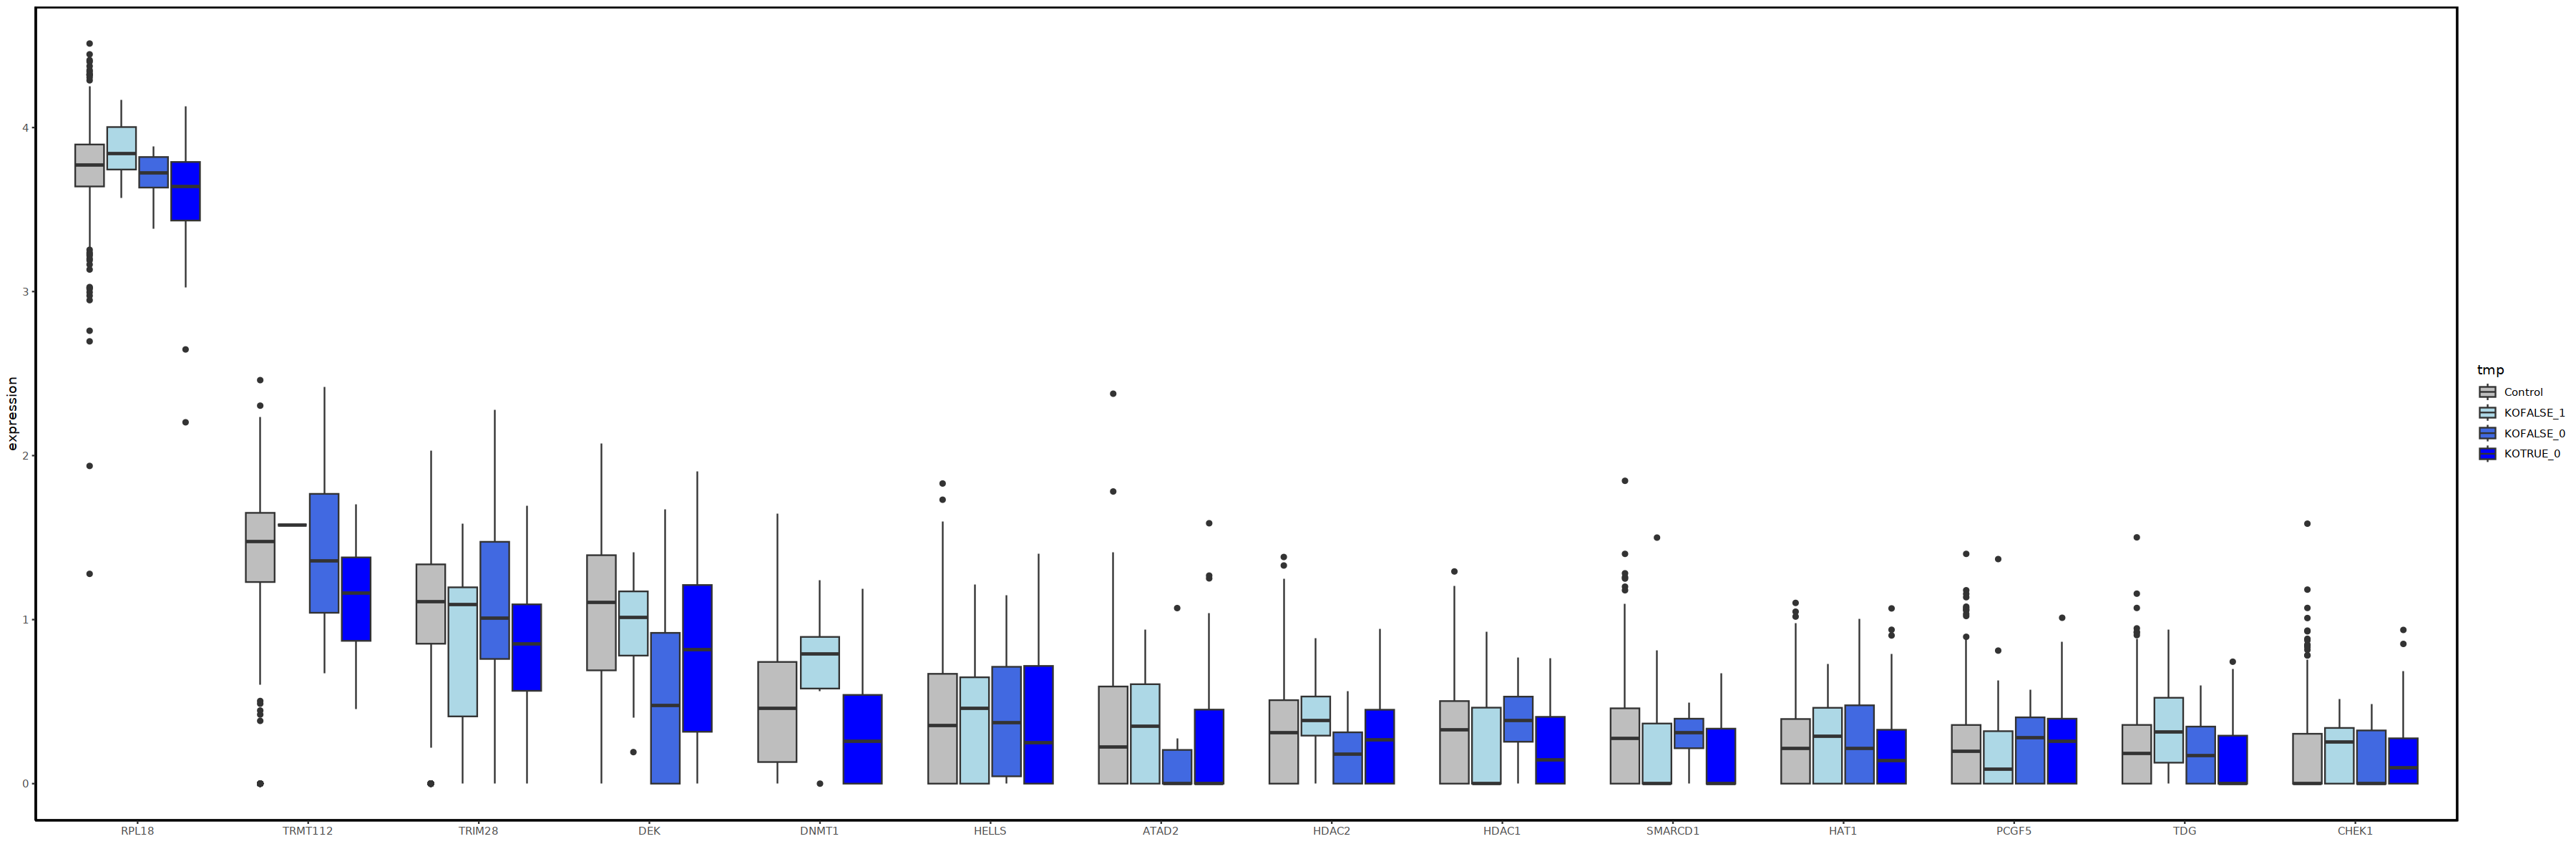

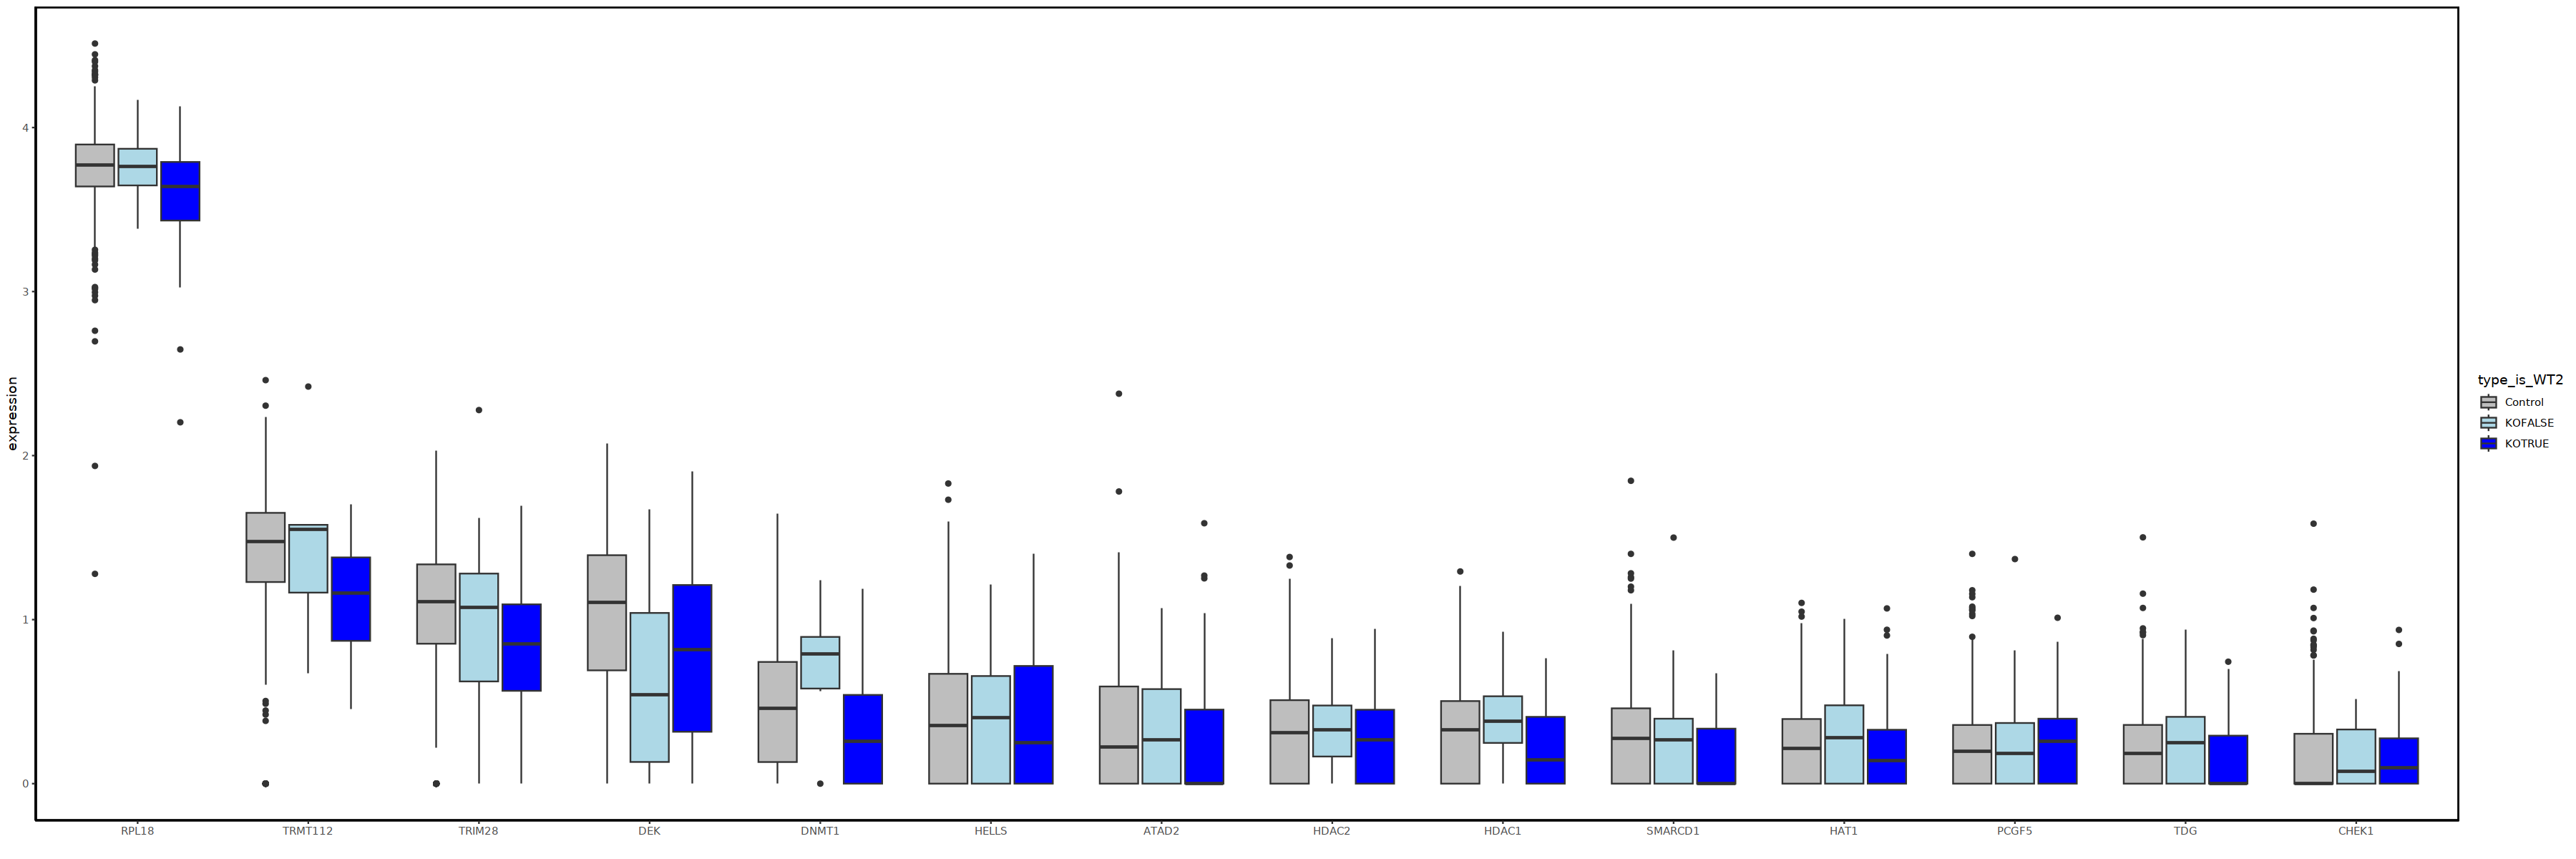

In [54]:
options(repr.plot.width=30,repr.plot.height=10)


#pdf('Figure2d_high_exp_targets_seperate_genes.pdf', width = 30, height = 10)
tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),]
tmp.df$tmp <- factor(tmp.df$tmp, levels = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"))
ggplot(tmp.df, 
       aes(x = reorder(target, -expression), y = expression, 
           fill = tmp)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                  values=c("grey", "lightblue",'royalblue','blue'))+

geom_boxplot(notch = FALSE)+theme_classic()+
#stat_compare_means(comparisons = my_comparisons, label = "p.signif")+
xlab('')+theme(panel.border = element_rect(colour = 'black', fill = NA, size = 1))


ggplot(tmp.df, 
       aes(x = reorder(target, -expression), y = expression, fill = type_is_WT2)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"), 
                  values=c("grey", "lightblue",'blue'))+
geom_boxplot(notch = FALSE)+theme_classic()+
#stat_compare_means(comparisons = my_comparisons, label = "p.signif")+
xlab('')+theme(panel.border = element_rect(colour = 'black', fill = NA, size = 1))

rm(tmp.df)
#dev.off()

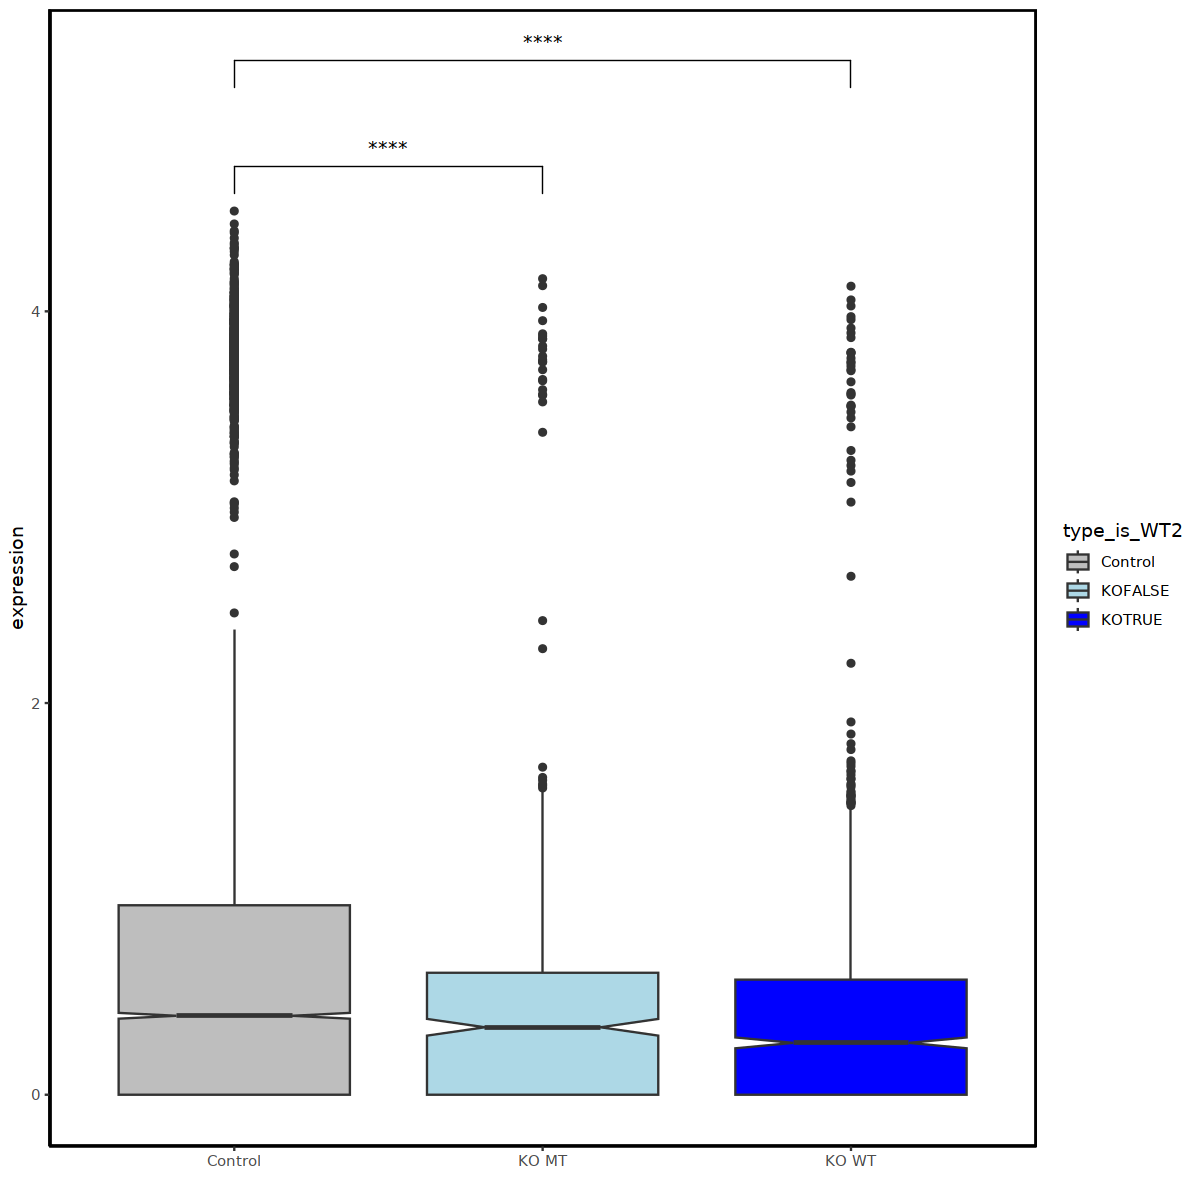

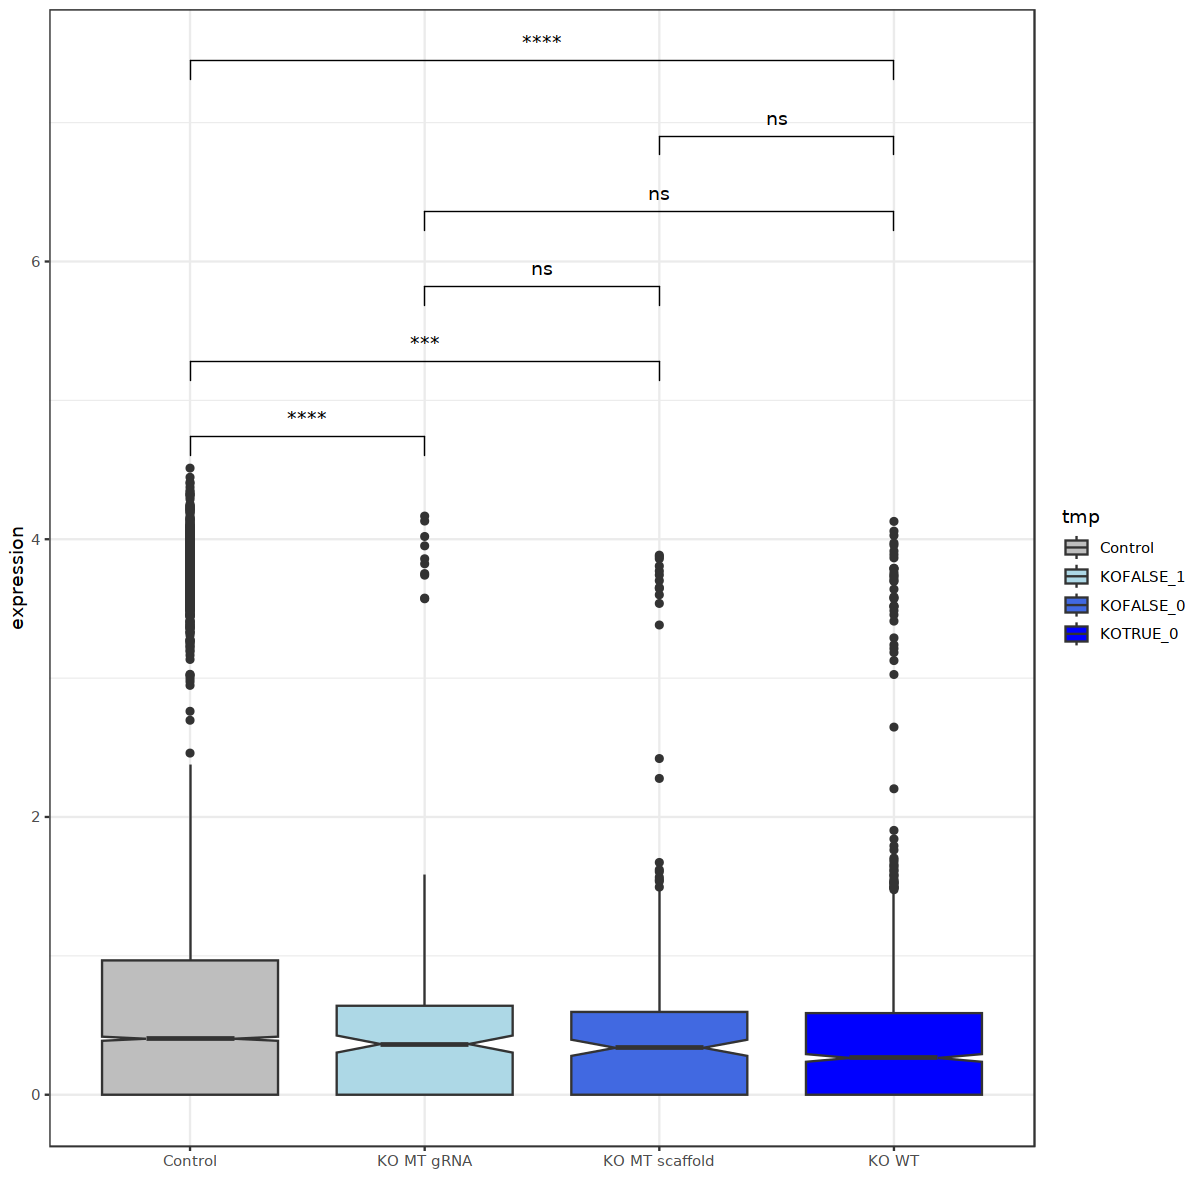

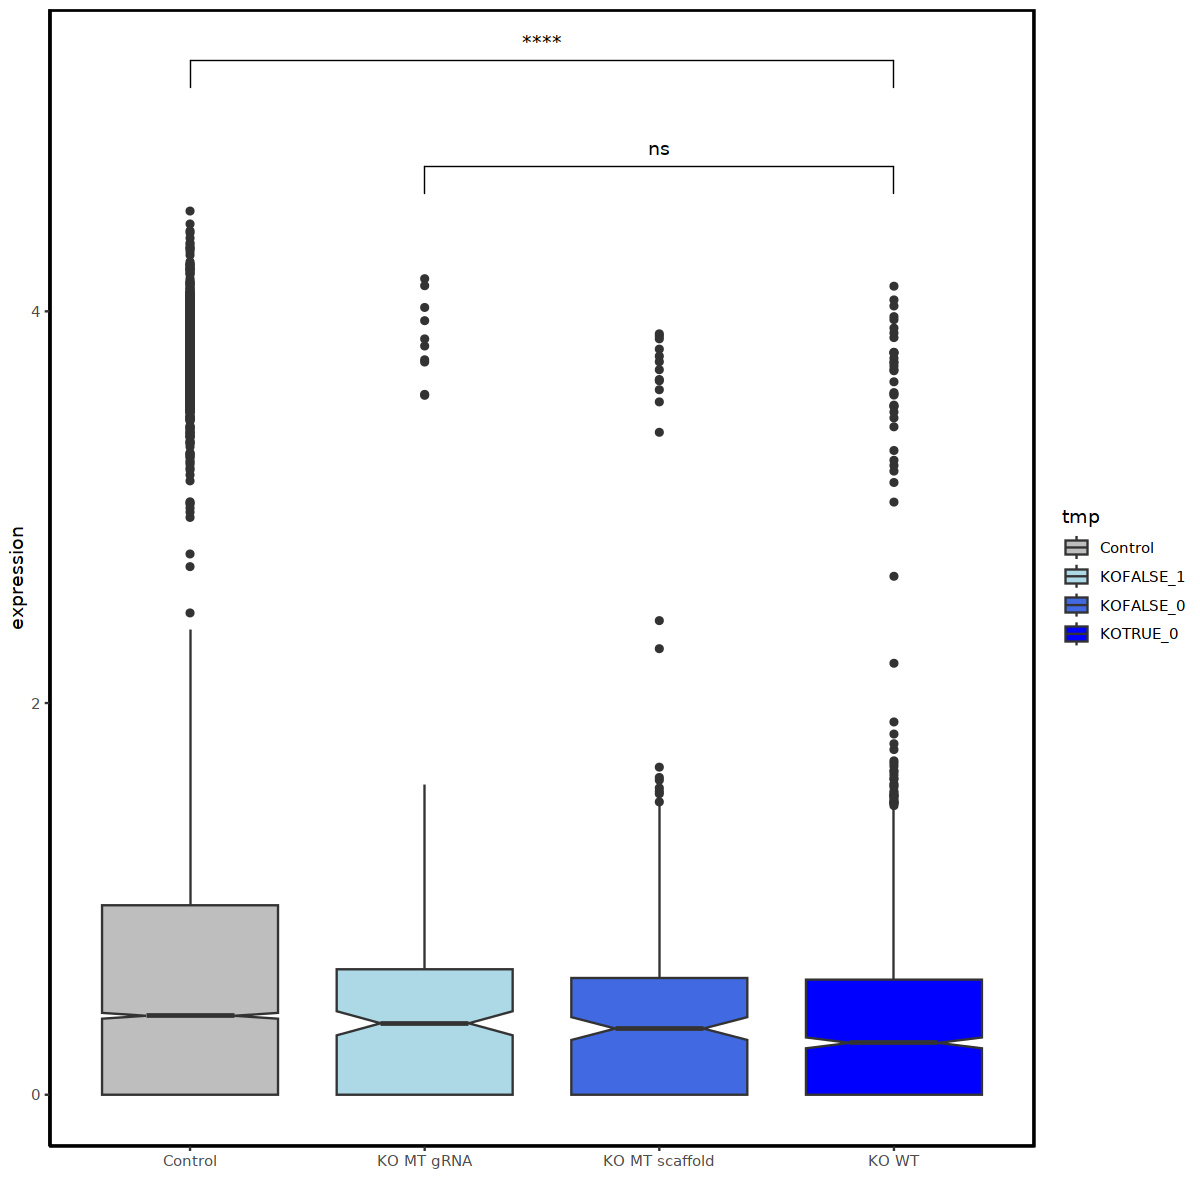

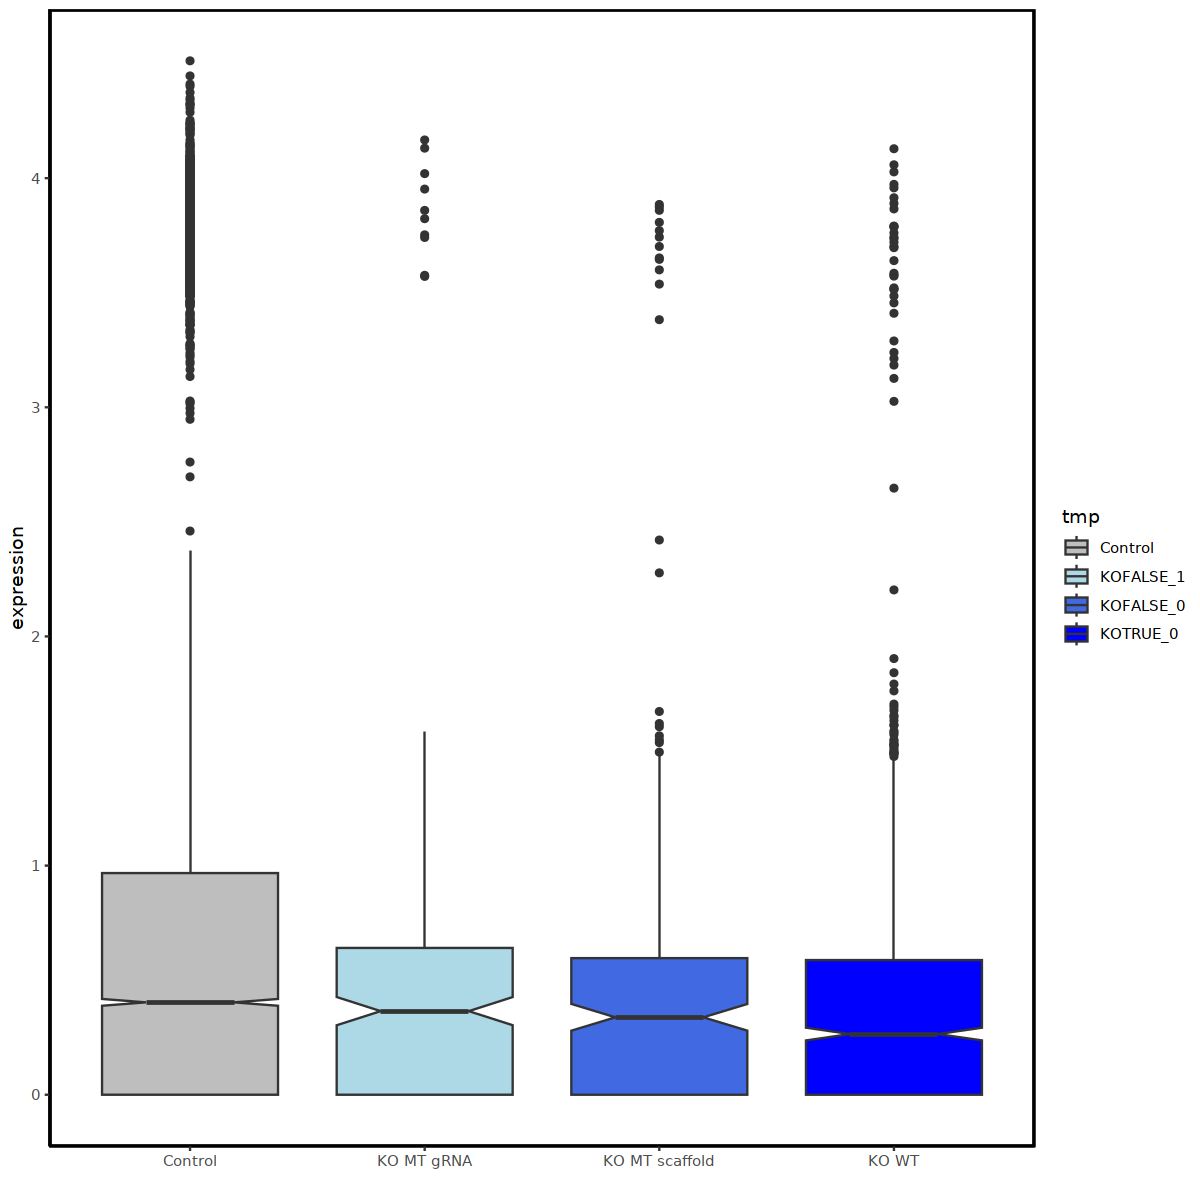

In [55]:
options(repr.plot.width=10,repr.plot.height=10)


#pdf('Figure2d_high_exp_targets.pdf')

my_comparisons <- list( c("KOFALSE", "Control"), c("KOTRUE", "Control") )
ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = type_is_WT2, y = expression, fill = type_is_WT2)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"), 
                  values=c("grey", "lightblue",'blue'))+
scale_x_discrete(labels=c("Control" = "Control", "KOFALSE" = "KO MT","KOTRUE" = "KO WT"))+
geom_boxplot(notch = TRUE)+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 't.test')+xlab('')


my_comparisons <- list(c("KOFALSE_1", "Control"), c("KOFALSE_0", "Control"),
                       c("KOFALSE_1", "KOFALSE_0"), 
                       c("KOFALSE_1", "KOTRUE_0"), 
                       c("KOFALSE_0", "KOTRUE_0"),  
                       c("KOTRUE_0", "Control"))
ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = tmp, y = expression, fill = tmp)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                  values=c("grey", "lightblue",'royalblue','blue'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))+
geom_boxplot(notch = TRUE)+theme_bw()+stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 't.test')+xlab('')

my_comparisons <- list(
                       c("KOFALSE_1", "KOTRUE_0"),
                       c("KOTRUE_0", "Control"))
ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = tmp, y = expression, fill = tmp)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                  values=c("grey", "lightblue",'royalblue','blue'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))+
geom_boxplot(notch = TRUE)+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 't.test')+xlab('')



ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = tmp, y = expression, fill = tmp)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                  values=c("grey", "lightblue",'royalblue','blue'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))+
geom_boxplot(notch = TRUE)+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+xlab('')

#dev.off()


# MT gRNA impact

In [56]:
# output_dir = './tmp/test'
input_dir = './GiRAFR_outputs/inhouse/'
fba_input_dir = '/lustre1/project/stg_00064/projects/cropseq/feature_barcoding_analysis/exp2_deep/exp2_deep_run_on_node/'

# MT <- plot_MT_pattern(input_dir, output_dir)


In [57]:
cells_gRNA_file <- paste0(input_dir, '/cells.gRNA.txt')
n_col = max(count.fields(cells_gRNA_file, sep = "\t"))
cells.gRNA <- read.table(cells_gRNA_file, 
                     header = FALSE, fill = TRUE, stringsAsFactors = FALSE,col.names =1:n_col)

colnames(cells.gRNA)[1:7]= c('cb','feature_order','target','WT','num_UMI_WT', 'MT','num_UMI_MT')
cells.gRNA$cb <- paste0(cells.gRNA$cb,'-1')
cells.gRNA.ori <- cells.gRNA
    
cells.num_features <- cells.gRNA %>% group_by(cb) %>% summarise(num_features = max(feature_order))    
cells.has_MT <- cells.gRNA %>% group_by(cb) %>% summarise(is_MT = grepl('variant', MT)) %>% summarise(has_MT=any(is_MT))
table(cells.num_features$num_features)
sum(table(cells.num_features$num_features))

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'cb'. You can override using the `.groups`
argument.



   1    2    3    4 
3593  286   16    4 

[1] 3899

## Analysis impact of mutant gRNA and doublets

In [58]:
input_dir

[1] "./GiRAFR_outputs/inhouse/"

In [59]:
cells.gRNA.single.MT <- read.table(paste0(input_dir, 'cells.gRNA.single.MT.txt'), stringsAsFactors = FALSE)
cells.gRNA.single.MT$target <- sapply(strsplit(cells.gRNA.single.MT$V3,"_"), `[`, 1)
cells.gRNA.single.MT[grepl('CTRL',cells.gRNA.single.MT$target),]$target <- 'Control'
cells.gRNA.single.MT$is_WT <- !grepl(pattern = 'variant',cells.gRNA.single.MT$V3)
#table(cells.gRNA.single.MT$is_WT)
cells.gRNA.single.MT$cb = paste0(cells.gRNA.single.MT$V1, '-1')

In [60]:
diff_cb <- pipeline_Single[!pipeline_Single %in% cells.gRNA.single.MT$cb]

In [61]:
length(diff_cb)

[1] 0

pipeline_Single

In [62]:
all.matrix <- Read10X(paste0(fba_input_dir,'/outs/filtered_feature_bc_matrix/'))
expression.seurat.ori = CreateSeuratObject(counts = all.matrix$`Gene Expression`)
expression.seurat <- subset(expression.seurat.ori, cells = pipeline_Single)

expression.seurat <- NormalizeData(object = expression.seurat, normalization.method = "LogNormalize", scale.factor = 10000)
rownames(cells.gRNA.single.MT) <- cells.gRNA.single.MT$cb
expression.seurat@meta.data$KO <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'target']
expression.seurat@meta.data$is_WT <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'is_WT']
expression.seurat@meta.data$mutation <- cells.gRNA.single.MT[rownames(expression.seurat@meta.data),'V5']
expression.seurat@meta.data$cb <- rownames(expression.seurat@meta.data)

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [63]:
expression.seurat

An object of class Seurat 
33538 features across 3593 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [64]:
sum(is.na(expression.seurat@meta.data$KO)) 
# should be same as length(diff_cb) 

[1] 0

In [65]:
table(expression.seurat@meta.data$is_WT) # cell wiltype vs mutant type


FALSE  TRUE 
 1033  2560 

In [66]:
rownames(cells.has_MT) <- cells.has_MT$cb
expression.seurat@meta.data$has_MT <- cells.has_MT[rownames(expression.seurat@meta.data), ]$has_MT

Warning message:
“Setting row names on a tibble is deprecated.”


In [67]:
diff_cb_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% diff_cb),]
rownames(diff_cb_gRNA) <- diff_cb_gRNA$cb

In [68]:
# replace KO NA into target
expression.seurat@meta.data$KO[which(expression.seurat@meta.data$cb %in% diff_cb)] <- 
sapply(strsplit(diff_cb_gRNA[rownames(expression.seurat@meta.data[which(expression.seurat@meta.data$cb %in% diff_cb),]), 'target'], '_'), `[`, 1)

In [69]:
gRNA_targets <- unlist(unique(expression.seurat@meta.data$KO))
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
#h <- hist(rowSums(expression.seurat@assays$RNA@counts[gRNA_targets[gRNA_targets!='Control'], CTRL_cells] < 1), plot = FALSE,breaks = 100)
#plot(h, xlab = 'Number of cells with counts < 1', main = 'Expression < 1 in control cells')
high_exp_targets <- gRNA_targets[gRNA_targets!='Control'][rowSums(expression.seurat@assays$RNA@counts[gRNA_targets[gRNA_targets!='Control'], 
                                                                                                        CTRL_cells] < 1) <= 400]
high_exp_targets
length(high_exp_targets)

[1] "CHEK1"   "DEK"     "DNMT1"   "ATAD2"   "PCGF5"   "HDAC1"   "TDG"    
 [8] "HDAC2"   "HAT1"    "HELLS"   "SMARCD1" "RPL18"   "TRIM28"  "TRMT112"

[1] 14

In [70]:
table(expression.seurat@meta.data$is_WT, expression.seurat@meta.data$has_MT)
# has some discrepancy 

       
        FALSE TRUE
  FALSE     0 1033
  TRUE   2560    0

In [71]:
#expression.seurat@meta.data[which(expression.seurat@meta.data$is_WT == FALSE & expression.seurat@meta.data$has_MT == FALSE),]

In [72]:
targets <- unique(expression.seurat@meta.data$KO)
targets <- targets[targets!='Control']
all.exp2.df <- data.frame()
CTRL_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == 'Control'),])
for(gene in targets){
        KO_cells <- row.names(expression.seurat@meta.data[which(expression.seurat@meta.data$KO == gene),])
        tmp.df <- rbind(data.frame(expression = expression.seurat@assays$RNA@data[gene, KO_cells], type = 'KO'),
            data.frame(expression = expression.seurat@assays$RNA@data[gene, CTRL_cells], type = 'Control'))

        tmp.df$target = gene
        tmp.df$cb = rownames(tmp.df)
        all.exp2.df <- rbind(all.exp2.df, tmp.df)
}

Target gene expression in Control

In [73]:
avg.exp.control <- all.exp2.df[which(all.exp2.df$type == 'Control'),] %>% group_by(target) %>% summarise(avg = mean(expression))
avg.exp.control <- as.data.frame(avg.exp.control)
rownames(avg.exp.control) <- avg.exp.control$target

In [74]:
table(all.exp2.MT.df$type_has_MT)

< table of extent 0 >

In [75]:
all.exp2.MT.df <- merge(all.exp2.df, cells.gRNA.single.MT[,c(4,5,8,9)], by = 'cb')
all.exp2.MT.df$type_is_WT <- paste0(all.exp2.MT.df$type, all.exp2.MT.df$is_WT)
all.exp2.MT.df$type_is_WT2 <- all.exp2.MT.df$type_is_WT
all.exp2.MT.df[which(all.exp2.MT.df$type_is_WT == 'ControlFALSE' |
                    all.exp2.MT.df$type_is_WT == 'ControlNA' |
                    all.exp2.MT.df$type_is_WT == 'ControlTRUE'),'type_is_WT2'] <- 'Control'

In [76]:
table(all.exp2.MT.df$type_is_WT2)


Control KOFALSE  KOTRUE 
  18925     832    2004 

In [77]:
all.exp2.MT.df$MT_gRNA <- ifelse(grepl(pattern = 'gRNA', all.exp2.MT.df$V5), 1,0)
all.exp2.MT.df$MT_U6 <- ifelse(grepl(pattern = 'U6', all.exp2.MT.df$V5), 1,0)
all.exp2.MT.df$MT_Rest <- ifelse(grepl(pattern = 'Rest', all.exp2.MT.df$V5), 1,0)
all.exp2.MT.df$tmp <- paste(all.exp2.MT.df$type_is_WT2, all.exp2.MT.df$MT_gRNA, sep = '_')
all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'Control_0' |
                    all.exp2.MT.df$tmp == 'Control_1'),'tmp'] <- 'Control'
table(all.exp2.MT.df$tmp)


  Control KOFALSE_0 KOFALSE_1  KOTRUE_0 
    18925       380       452      2004 

tmp,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,18925,1.0000000,5.769032,0.04193581
KOFALSE_0,380,1.0258393,1.220308,0.06260046
KOFALSE_1,452,1.0991485,1.373894,0.06462252
KOTRUE_0,2004,0.7694321,1.352518,0.03021302


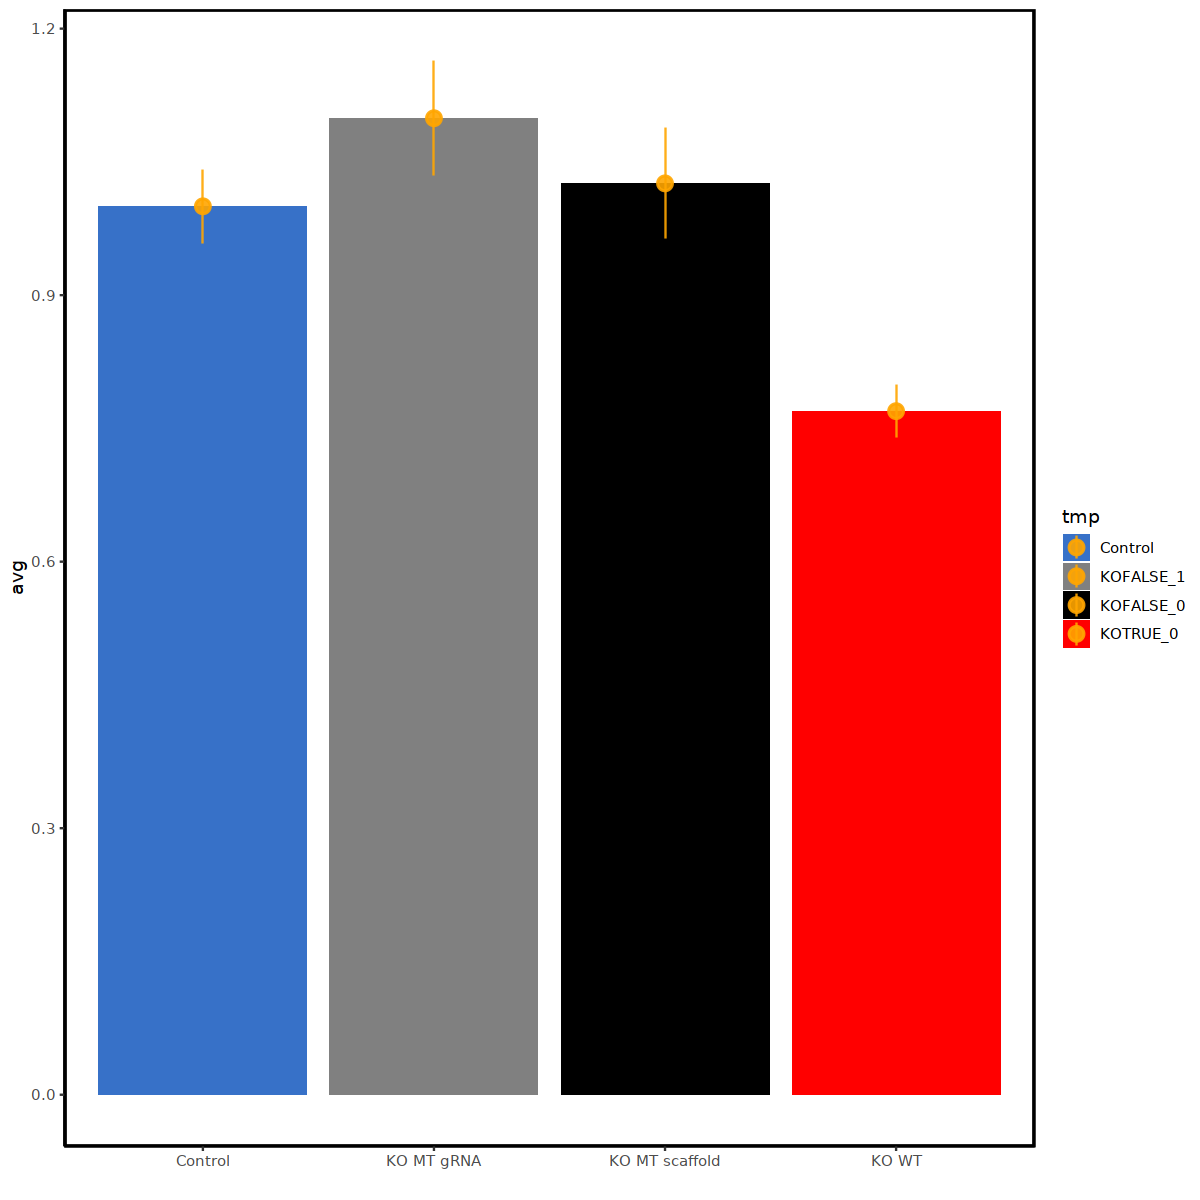

tmp,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,10598,1.0000000,0.8807291,0.008555205
KOFALSE_0,261,0.9095394,0.8279447,0.051248490
KOFALSE_1,271,1.1312500,1.0220928,0.062087715
KOTRUE_0,1123,0.8366918,0.8749148,0.026108138


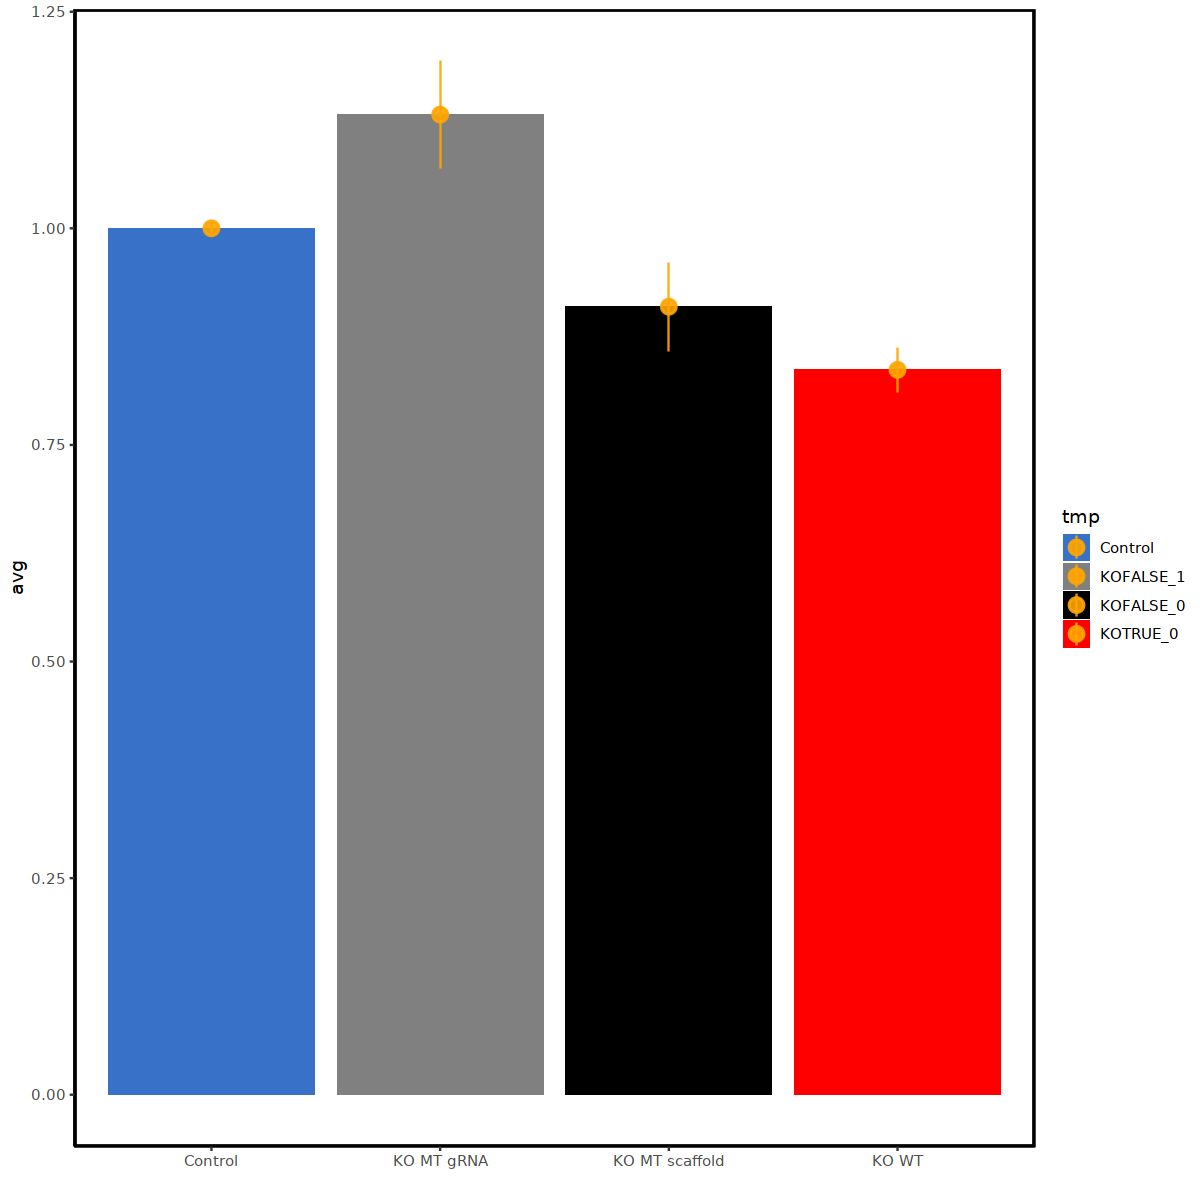

In [78]:
options(repr.plot.width=10,repr.plot.height=10)
all.exp2.MT.df$expression_norm <- all.exp2.MT.df$expression/avg.exp.control[all.exp2.MT.df$target,'avg']


## all targets
tmp.df <- all.exp2.MT.df[, c('tmp','expression_norm')]
tmp.df <- tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = tmp, y = avg, fill = tmp)) + geom_col()+
        geom_pointrange(aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                   values=c("#3771c8", "#808080",'#000000','#ff0000'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), 
                 labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))

print(p1)
tmp.df

## high_exp_targets
tmp.df <- all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets), c('tmp','expression_norm')]
tmp.df <- tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm),
                                                 sem = sd(expression_norm)/sqrt(n))

p1 <- ggplot(tmp.df, aes(x = tmp, y = avg, fill = tmp)) + geom_col()+
        geom_pointrange(aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
        theme_classic()+
        xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))+
scale_fill_manual(breaks = c("Control", "KOFALSE_1","KOFALSE_0","KOTRUE_0"), 
                   values=c("#3771c8", "#808080",'#000000','#ff0000'))+
scale_x_discrete(limits = c("Control", "KOFALSE_1", "KOFALSE_0", "KOTRUE_0"), 
                 labels=c("Control" = "Control", "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold", "KOTRUE_0" = "KO WT"))

print(p1)
tmp.df

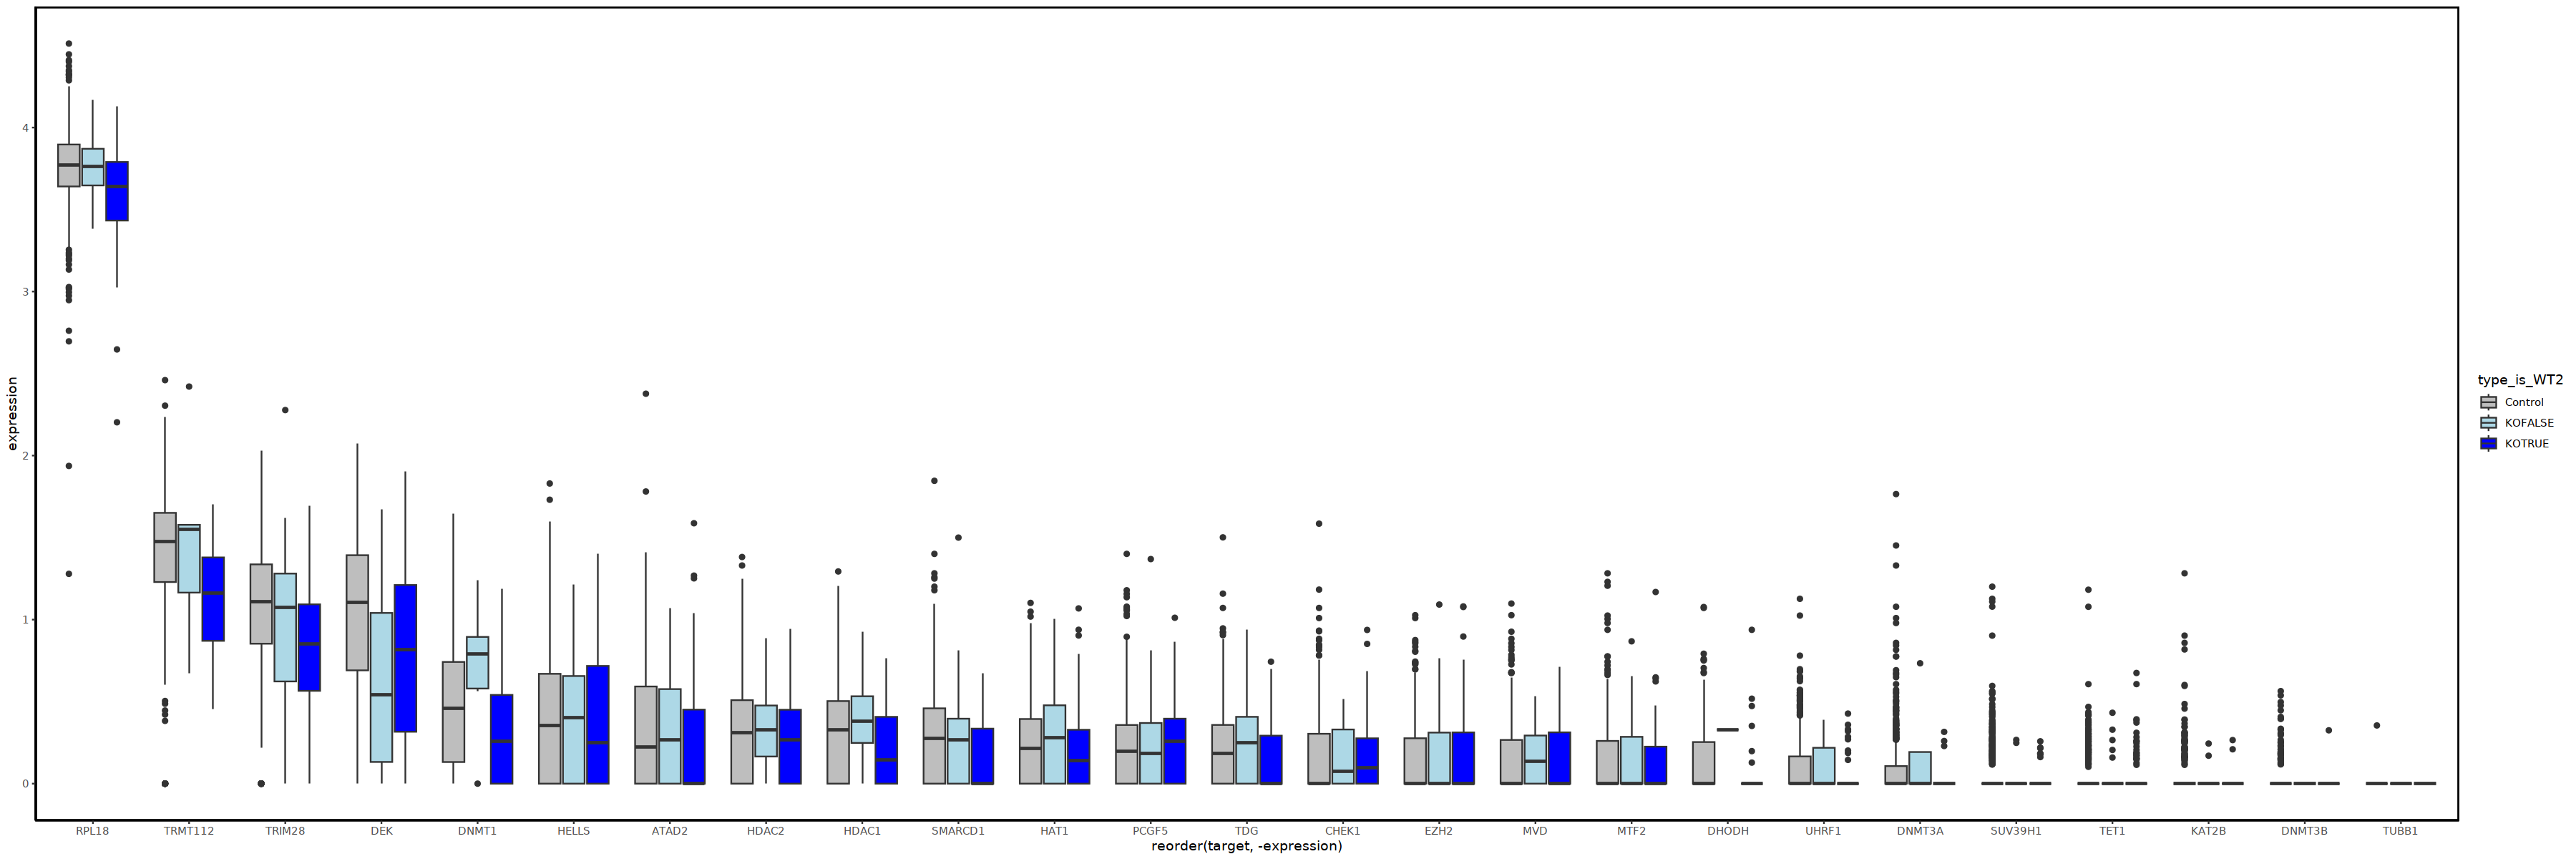

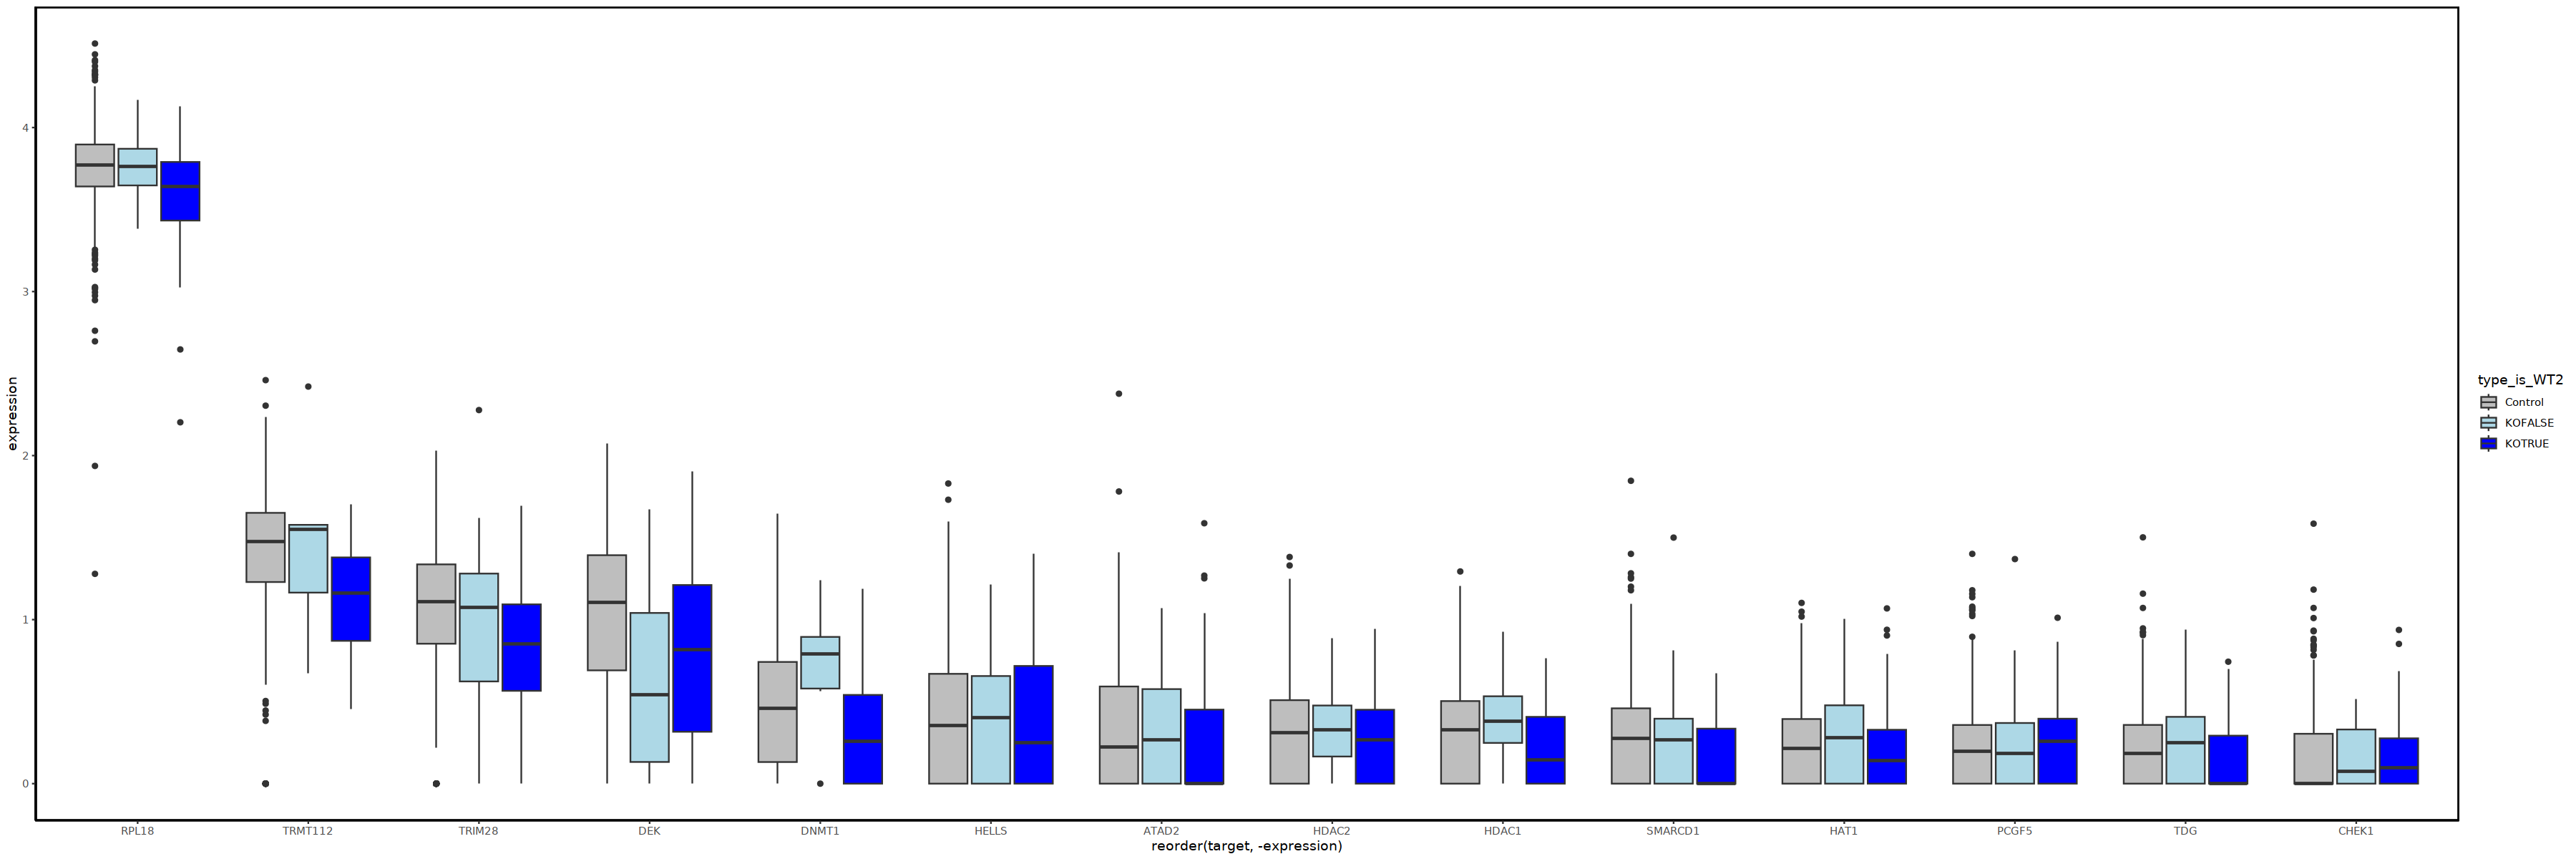

In [79]:
options(repr.plot.width=30,repr.plot.height=10)

#pdf('exp2_targets_seperate_genes.pdf', width = 30, height = 10)


ggplot(all.exp2.MT.df, aes(x = reorder(target, -expression), y = expression, fill = type_is_WT2)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"), 
                  values=c("grey", "lightblue",'blue'))+
geom_boxplot()+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))

ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = reorder(target, -expression), y = expression, fill = type_is_WT2)) + 
scale_fill_manual(breaks = c("Control", "KOFALSE","KOTRUE"), 
                  values=c("grey", "lightblue",'blue'))+
geom_boxplot()+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


#dev.off()

## Analysis impact of doublets/multiplets

In [80]:
protospacer_file <- paste0(fba_input_dir, '/outs/crispr_analysis/protospacer_calls_per_cell.csv')
barcodes_file <- paste0(fba_input_dir, '/outs/filtered_feature_bc_matrix/barcodes.tsv.gz')

protospacer_calls_per_cell <-read.csv(protospacer_file, stringsAsFactors = FALSE)
cellranger_barcode <- read_csv(barcodes_file, col_names = FALSE)


all_barcodes <- as.data.frame(cellranger_barcode)
all_barcodes$pipeline_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 1, 0)
all_barcodes$pipeline_empty_cell <- ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 0, 1)
all_barcodes$pipeline_not_single_cell <- ifelse(all_barcodes$X1 %in% pipeline_Single, 0, 
                                            ifelse(all_barcodes$X1 %in% pipeline_NotEmpty, 1, 0))

all_barcodes$cellranger_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 1, 0)
all_barcodes$cellranger_empty_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 0, 1)
all_barcodes$cellranger_not_single_cell <- ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode[protospacer_calls_per_cell$num_features == 1], 0, 
                                            ifelse(all_barcodes$X1 %in% protospacer_calls_per_cell$cell_barcode, 1, 0))
all_barcodes <- merge(all_barcodes, cells.has_MT, by.x = 'X1', by.y = 'cb', all.x = TRUE)


Rows: 5744 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [81]:
new_doublets <- all_barcodes[which(all_barcodes$pipeline_not_single_cell == 1 & all_barcodes$cellranger_single_cell == 1), 'X1']
length(new_doublets) 
# pipeline identified doubets, cellranger as single

[1] 49

For new doublets, following scenarios:
1. doublets with the mutant gRNA and wildtype gRNA targeting the same gene, 
2. doublets with the mutant gRNA and wildtype gRNA targeting the different gene
3. doublets with two wildtype gRNA targeting the same gene
4. doublets with two wildtype gRNA targeting different gene
5. doublets with two mutant gRNAs targeting different gene

In [82]:
new_doublets_gRNA <- cells.gRNA[which(cells.gRNA$cb %in% new_doublets),] # the mutant gRNA and wildtype gRNA targeting the same gene,


In [83]:
#new_doublets_type1 <- new_doublets_gRNA[which(new_doublets_gRNA$feature_order >= 2),]
#new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA[which(new_doublets_gRNA$feature_order < 2),] %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))

In [84]:
new_doublets_gRNA2 <- as.data.frame(new_doublets_gRNA %>% group_by(cb) %>% summarise(target = list(target), UMIs = list(num_UMI_WT)))

In [85]:
new_doublets_gRNA2$KO <- lapply(new_doublets_gRNA2$target, function(x) sapply(strsplit(x, '_'), `[`, 1))
                                

In [86]:
if1 <- lapply(new_doublets_gRNA2$KO, function(x) x[1]== x[2])
if2 <- lapply(new_doublets_gRNA2$UMIs, function(x) x[1]>0 & x[2] > 0)
              
new_doublets_type_unknown <- c()
new_doublets_type2 <- c()
new_doublets_type3 <- c()
new_doublets_type4 <- c()
new_doublets_type5 <- c()
for(i in 1:nrow(new_doublets_gRNA2)){
    if(is.na(if1[i]) | is.na(if2[i])){
        new_doublets_type_unknown <- rbind(new_doublets_type_unknown, new_doublets_gRNA2[i,])
    }else{
    if(if1[i] == TRUE & if2[i] == TRUE){ # two wiltype gRNA targeting the same target
        new_doublets_type3 <- rbind(new_doublets_type3, new_doublets_gRNA2[i,])
    }else if(if1[i] == TRUE & if2[i] == FALSE){ #  mutant gRNA and wildtype gRNA or two muatnt targeting the same gene
        new_doublets_type2 <- rbind(new_doublets_type2, new_doublets_gRNA2[i,])
    }else if(if1[i] == FALSE & if2[i] == TRUE){# two wildtype gRNA targeting different gene
        new_doublets_type4 <- rbind(new_doublets_type4, new_doublets_gRNA2[i,]) 
    }else if(if1[i] == FALSE & if2[i] == FALSE){ # mutant gRNA and wildtype gRNA or two muatnt  different gene 
        new_doublets_type5 <- rbind(new_doublets_type5, new_doublets_gRNA2[i,])
    }else{
        print('unknown error')
    }
    }
}

In [87]:
#nrow(new_doublets_type1)
nrow(new_doublets_type2)
nrow(new_doublets_type3)
nrow(new_doublets_type4)
nrow(new_doublets_type5)
nrow(new_doublets_type_unknown)

NULL

NULL

NULL

[1] 49

NULL

In [88]:
new_doublets_subset <- rbind(new_doublets_type4, new_doublets_type5)$cb
length(new_doublets_subset)

[1] 49

In [89]:
seurat.object.doublets <- subset(expression.seurat.ori, cells = new_doublets_subset)
seurat.object.doublets <- NormalizeData(object = seurat.object.doublets, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.object.doublets

An object of class Seurat 
33538 features across 49 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data

In [90]:
head(rbind(new_doublets_type4, new_doublets_type5))

,cb,target,UMIs,KO
,<chr>,<list>,<list>,<list>
1,AACCACAAGCTGTCCG-1,"EZH2_gRNA4_gene , KAT2B_gRNA4_gene","0, 58","EZH2 , KAT2B"
2,AAGTGAACACAGTCGC-1,"TDG_gRNA4_gene , HDAC2_gRNA4_gene","0, 0","TDG , HDAC2"
3,AATCACGAGCATTGTC-1,"SMARCD1_gRNA3_gene, CTRL00022_gene","0, 49","SMARCD1 , CTRL00022"
4,ACATCGACACTCCCTA-1,"HDAC2_gRNA3_gene, CTRL00196_gene","64, 0","HDAC2 , CTRL00196"
5,ACGGTCGCATAATGAG-1,"SMARCD1_gRNA4_gene, RPL18_gRNA3_gene","24, 0","SMARCD1, RPL18"
6,ACGTACAAGCACCCAC-1,"MVD_gRNA2_gene , HDAC2_gRNA1_gene","0, 42","MVD , HDAC2"


In [91]:
new_doublets_gRNA[which(new_doublets_gRNA$cb %in% seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),'cell_barcode']),]

cb,feature_order,target,WT,num_UMI_WT,MT,num_UMI_MT,X8
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<lgl>


In [92]:
protospacer.df <- read.csv(protospacer_file)
rownames(protospacer.df) <- protospacer.df$cell_barcode

In [93]:
seurat.object.doublets@meta.data <- cbind(seurat.object.doublets@meta.data, protospacer.df[colnames(seurat.object.doublets),])
seurat.object.doublets$KO <- sapply(strsplit(seurat.object.doublets@meta.data$feature_call, '_'), `[`, 4)

In [94]:
seurat.object.doublets$KO[is.na(seurat.object.doublets$KO)] <- 'Control'

In [95]:
unique(seurat.object.doublets$KO)

[1] "KAT2B"   "HDAC2"   "Control" "SMARCD1" "DEK"     "TET1"    "CHEK1"  
 [8] "EZH2"    "HAT1"    "HELLS"   "HDAC1"   "DHODH"   "TDG"     "SUV39H1"
[15] "TUBB1"   "MTF2"

In [96]:
doublets_targets <- unique(seurat.object.doublets$KO)[-which(unique(seurat.object.doublets$KO) == 'Control')] # remove 'neg'
doublets.exp.df <- data.frame()
CTRL_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == 'Control'),])

for(gene in doublets_targets){
    KO_cells <- row.names(seurat.object.doublets@meta.data[which(seurat.object.doublets@meta.data$KO == gene),])
   tmp.df <- rbind(data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, KO_cells], type = 'KO_doublets'),
                    data.frame(expression = seurat.object.doublets@assays$RNA@data[gene, CTRL_cells], type = 'Control_doublets'))
   tmp.df$target = gene
   tmp.df$cb = c(KO_cells, CTRL_cells)
   doublets.exp.df <- rbind(doublets.exp.df, tmp.df)
}

In [97]:
doublets.exp.df$type_is_WT2 <- doublets.exp.df$type

In [98]:
doublets.exp.df$expression_norm <- doublets.exp.df$expression/avg.exp.control[doublets.exp.df$target,'avg']

In [99]:
doublets.exp.df$tmp <- doublets.exp.df$type_is_WT2 

In [100]:
all.exp2.doublets.df <- rbind(doublets.exp.df[, c('expression', 'type', 'target', 'cb', 'tmp', 'expression_norm')]
                              , all.exp2.MT.df[, c('expression', 'type', 'target', 'cb', 'tmp', 'expression_norm')])

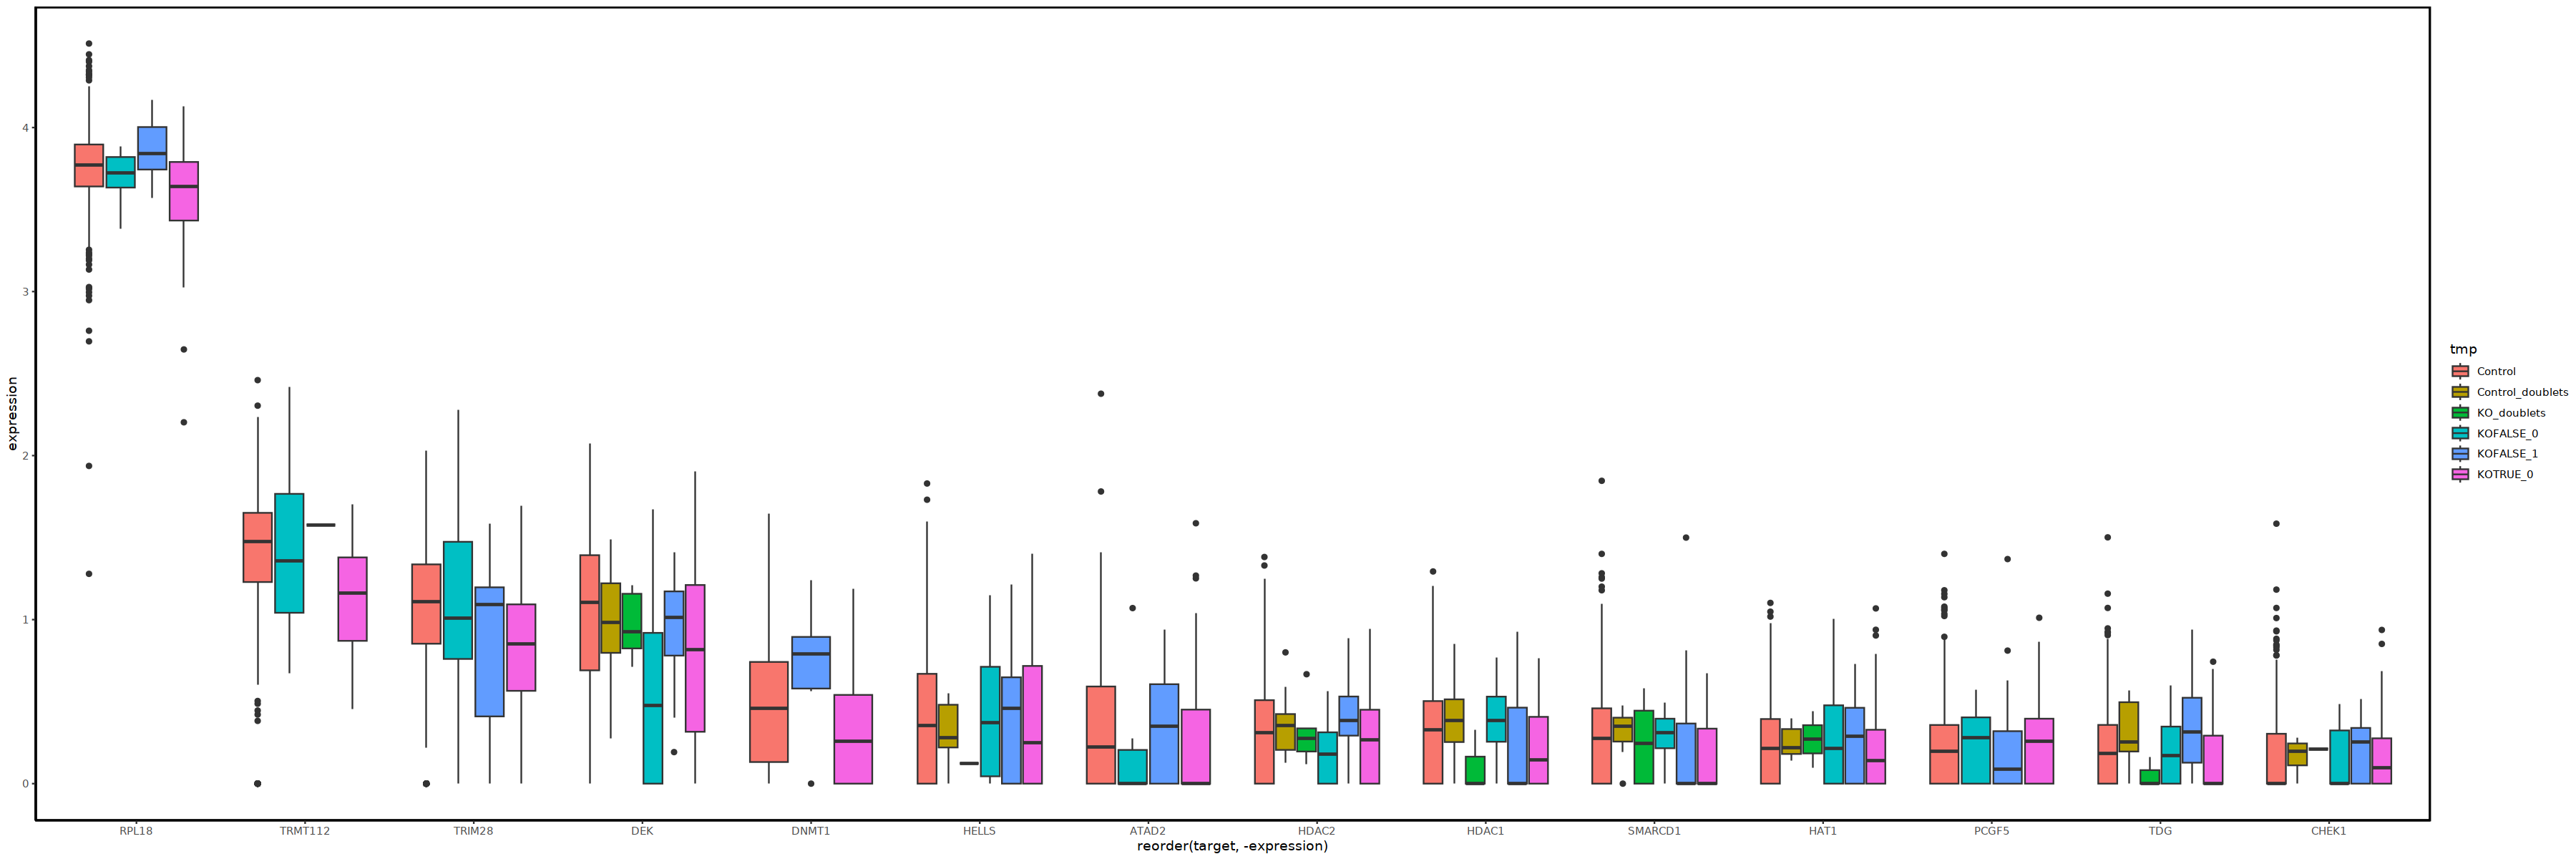

In [101]:
options(repr.plot.width=30,repr.plot.height=10)

ggplot(all.exp2.doublets.df[which(all.exp2.doublets.df$target %in% high_exp_targets),], aes(x = reorder(target, -expression), y = expression, fill = tmp)) + 
geom_boxplot()+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))

tmp,n,avg,sd,sem
<chr>,<int>,<dbl>,<dbl>,<dbl>
Control,10598,1.0000000,0.8807291,0.008555205
Control_doublets,64,1.0633195,0.6352741,0.079409268
KOFALSE_0,261,0.9095394,0.8279447,0.051248490
KOFALSE_1,271,1.1312500,1.0220928,0.062087715
KOTRUE_0,1123,0.8366918,0.8749148,0.026108138
KO_doublets,26,0.7863451,0.6217055,0.121926478


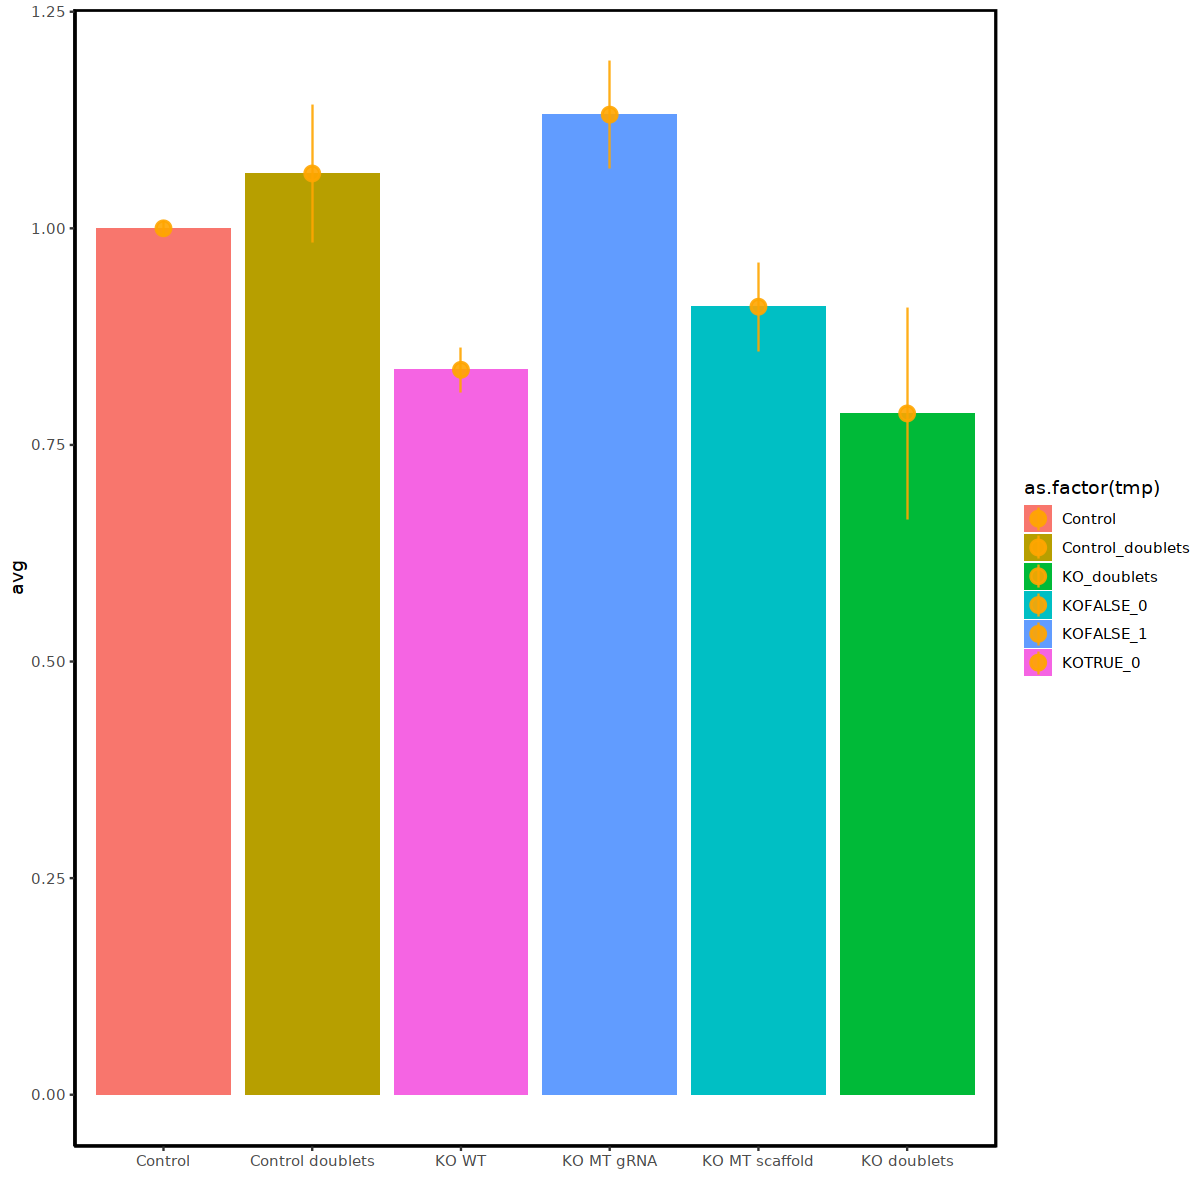

In [102]:
options(repr.plot.width=10,repr.plot.height=10)
#pdf('exp2_aggregated_expression_barplot_doublets.pdf')


# tmp.df <- all.exp2.doublets.df
# tmp.df <- tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
# tmp.df

# ggplot(tmp.df, 
#        aes(
#            x = tmp, 
#            y = avg, fill = as.factor(tmp))) + 
# geom_col()+
# geom_pointrange(aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
# theme_classic()+
# scale_x_discrete(limits = c('Control','Control_doublets','KOTRUE_0', 'KOFALSE_1', 'KOFALSE_0', 'KO_doublets'), 
#                  labels=c("Control" = "Control", "Control_doublets" = "Control doublets",  
#                           "KOTRUE_0" = "KO WT",
#                           "KOFALSE_1" = "KO MT gRNA",
#                           "KOFALSE_0" = "KO MT scaffold",
#                          "KO_doublets" = "KO doublets"))+
# xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))


tmp.df <- all.exp2.doublets.df[which(all.exp2.doublets.df$target %in% high_exp_targets),]
tmp.df <- tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
tmp.df

ggplot(tmp.df, 
       aes(
           x = tmp, 
           y = avg, fill = as.factor(tmp))) + 
geom_col()+
geom_pointrange(aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem), colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
scale_x_discrete(limits = c('Control','Control_doublets','KOTRUE_0', 'KOFALSE_1', 'KOFALSE_0', 'KO_doublets'), 
                 labels=c("Control" = "Control", "Control_doublets" = "Control doublets",  
                          "KOTRUE_0" = "KO WT",
                          "KOFALSE_1" = "KO MT gRNA",
                          "KOFALSE_0" = "KO MT scaffold",
                         "KO_doublets" = "KO doublets"))+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))

#dev.off()

In [103]:
table(tmp.df$tmp)


         Control Control_doublets      KO_doublets        KOFALSE_0 
               1                1                1                1 
       KOFALSE_1         KOTRUE_0 
               1                1 

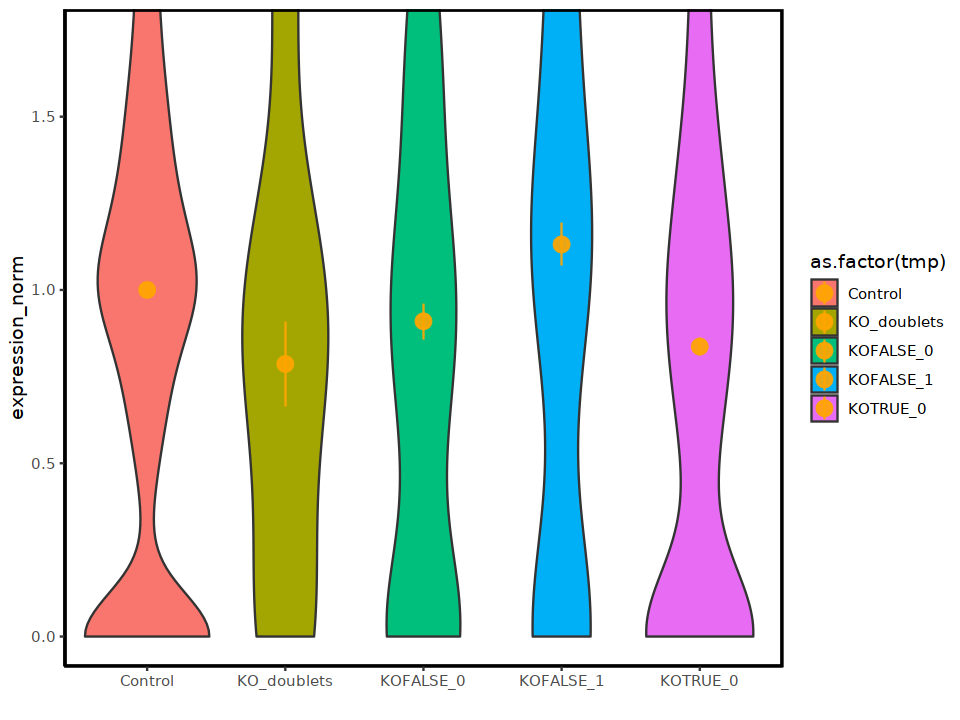

In [125]:
options(repr.plot.width=8,repr.plot.height=6)

#pdf('exp2_aggregated_expression_barplot_doublets_violin.pdf')

tmp.df <- all.exp2.doublets.df[which(all.exp2.doublets.df$target %in% high_exp_targets),]
tmp.df <- tmp.df[which(tmp.df$tmp != 'Control_doublets'),]

tmpp <-  tmp.df %>% group_by(tmp) %>% summarise(n = n(), avg = mean(expression_norm), 
                                                 sd = sd(expression_norm), sem = sd(expression_norm)/sqrt(n))
ylims <- tmp.df %>%
  group_by(tmp) %>%
  summarise(Q1 = quantile(expression_norm, 1/4), Q3 = quantile(expression_norm, 3/4)) %>%
  ungroup() %>%
  #get lowest Q1 and highest Q3
  summarise(lowQ1 = min(Q1), highQ3 = max(Q3))

ggplot(tmp.df, 
       aes(
           x = tmp, 
           y = expression_norm, fill = as.factor(tmp))) + 
geom_violin()+coord_cartesian(ylim = as.numeric(ylims)*1)+ # zoom in
geom_pointrange(data = tmpp, aes(x=tmp, y=avg, ymin=avg-sem, ymax=avg+sem),
                colour="orange", alpha=0.9, size=0.8)+
theme_classic()+
xlab('')+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
#dev.off()

Notch went outside hinges
ℹ Do you want `notch = FALSE`?


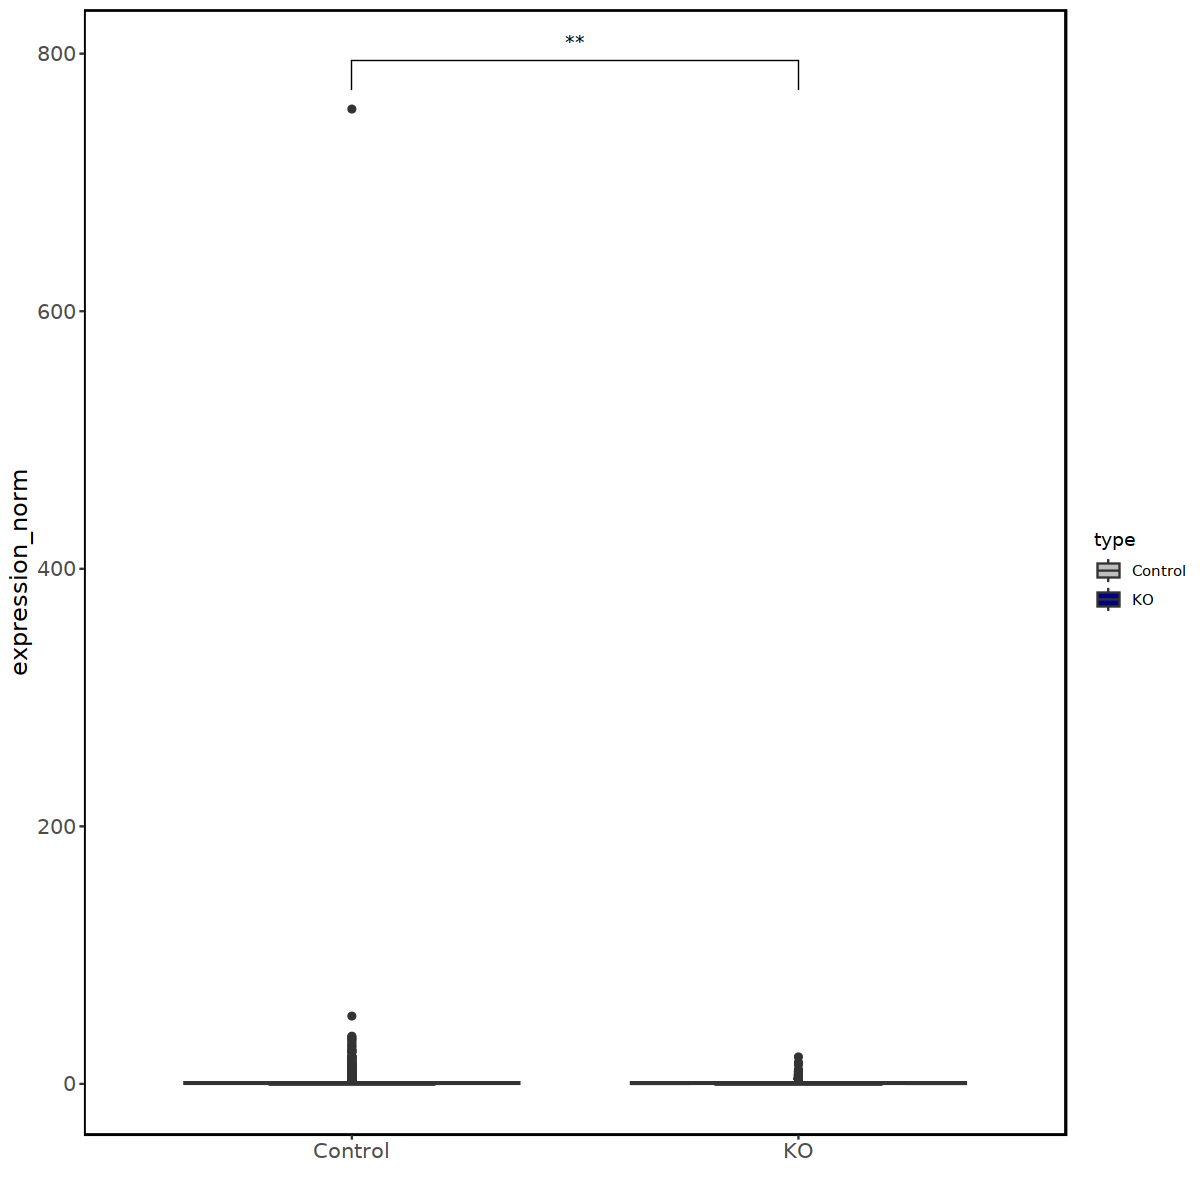

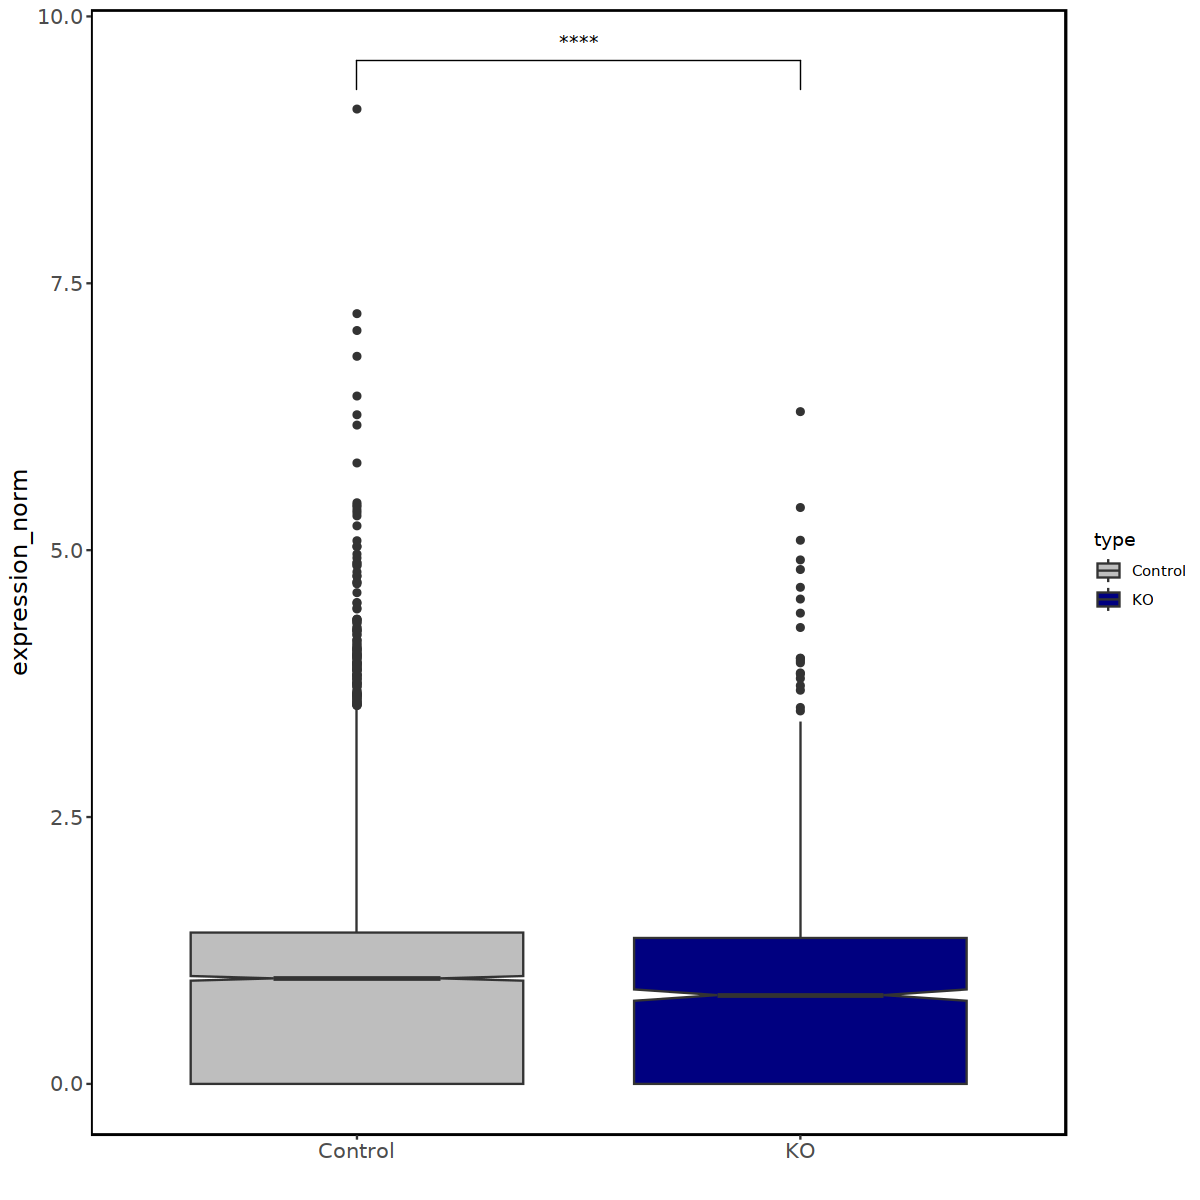

In [105]:
options(repr.plot.width=10,repr.plot.height=10)


my_comparisons <- list( c("KO", "Control"))
ggplot(all.exp2.MT.df, aes(x = type, y = expression_norm, fill = type)) + 
scale_fill_manual(breaks = c("Control", "KO"), 
                  values=c("grey", "navy"))+
geom_boxplot(notch = TRUE)+theme_classic()+
theme(panel.border =element_rect(colour = 'black', fill = NA, size = 1), 
      axis.line=element_blank(), 
      axis.title.x = element_text(size = 14),
      axis.text.x = element_text(size = 12),
      axis.text.y = element_text(size = 12),
      axis.title.y = element_text(size = 14))+
stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 't.test')+xlab('')


my_comparisons <- list( c("KO", "Control"))
ggplot(all.exp2.MT.df[which(all.exp2.MT.df$target %in% high_exp_targets),], aes(x = type, y = expression_norm, fill = type)) + 
scale_fill_manual(breaks = c("Control", "KO"), 
                  values=c("grey", "navy"))+
geom_boxplot(notch = TRUE)+theme_classic()+
theme(panel.border =element_rect(colour = 'black', fill = NA, size = 1), 
      axis.line=element_blank(), 
      axis.title.x = element_text(size = 14),
      axis.text.x = element_text(size = 12),
      axis.text.y = element_text(size = 12),
      axis.title.y = element_text(size = 14))+
stat_compare_means(comparisons = my_comparisons, label = "p.signif", method = 't.test')+xlab('')


In [106]:
# update MAY2023 all targets
# calculate intact gRNAs reduced target gene expression by on average XX % (P = XX)


control_exp <- all.exp2.MT.df[which(all.exp2.MT.df$type_is_WT2 == 'Control'),'expression_norm']
WT_gRNA_exp <- all.exp2.MT.df[which(all.exp2.MT.df$type_is_WT2 == 'KOTRUE'),'expression_norm']
MT_gRNA_exp <- all.exp2.MT.df[which(all.exp2.MT.df$type_is_WT2 == 'KOFALSE'),'expression_norm']


# t.test(control_exp, WT_gRNA_exp)
# t.test(control_exp, MT_gRNA_exp)


control_exp <- all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'Control'),'expression_norm']
WT_gRNA_exp <- all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'KOTRUE_0'),'expression_norm']
MT_scaff_gRNA_exp <- all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'KOFALSE_0'),'expression_norm']
MT_spacer_gRNA_exp <- all.exp2.MT.df[which(all.exp2.MT.df$tmp == 'KOFALSE_1'),'expression_norm']


t.test(control_exp, WT_gRNA_exp) # p-value 8.232e-06
t.test(control_exp, MT_scaff_gRNA_exp) # p-value = 0.7317
t.test(control_exp, MT_spacer_gRNA_exp) # 0.1984 
t.test(WT_gRNA_exp, MT_scaff_gRNA_exp)  # 0.0002469
t.test(WT_gRNA_exp, MT_spacer_gRNA_exp)  # 4.569e-06
t.test(MT_scaff_gRNA_exp, MT_spacer_gRNA_exp) # 0.4154



	Welch Two Sample t-test

data:  control_exp and WT_gRNA_exp
t = 4.4609, df = 12317, p-value = 8.232e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1292553 0.3318805
sample estimates:
mean of x mean of y 
1.0000000 0.7694321 



	Welch Two Sample t-test

data:  control_exp and MT_scaff_gRNA_exp
t = -0.34293, df = 792.29, p-value = 0.7317
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1737460  0.1220675
sample estimates:
mean of x mean of y 
 1.000000  1.025839 



	Welch Two Sample t-test

data:  control_exp and MT_spacer_gRNA_exp
t = -1.287, df = 906.99, p-value = 0.1984
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.25033981  0.05204275
sample estimates:
mean of x mean of y 
 1.000000  1.099149 



	Welch Two Sample t-test

data:  WT_gRNA_exp and MT_scaff_gRNA_exp
t = -3.6888, df = 570.27, p-value = 0.0002469
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3929340 -0.1198802
sample estimates:
mean of x mean of y 
0.7694321 1.0258393 



	Welch Two Sample t-test

data:  WT_gRNA_exp and MT_spacer_gRNA_exp
t = -4.622, df = 662.58, p-value = 4.569e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.4697892 -0.1896436
sample estimates:
mean of x mean of y 
0.7694321 1.0991485 



	Welch Two Sample t-test

data:  MT_scaff_gRNA_exp and MT_spacer_gRNA_exp
t = -0.8148, df = 827.48, p-value = 0.4154
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2499087  0.1032901
sample estimates:
mean of x mean of y 
 1.025839  1.099149 


In [107]:
length(control_exp)
length(WT_gRNA_exp)

[1] 18925

[1] 2004

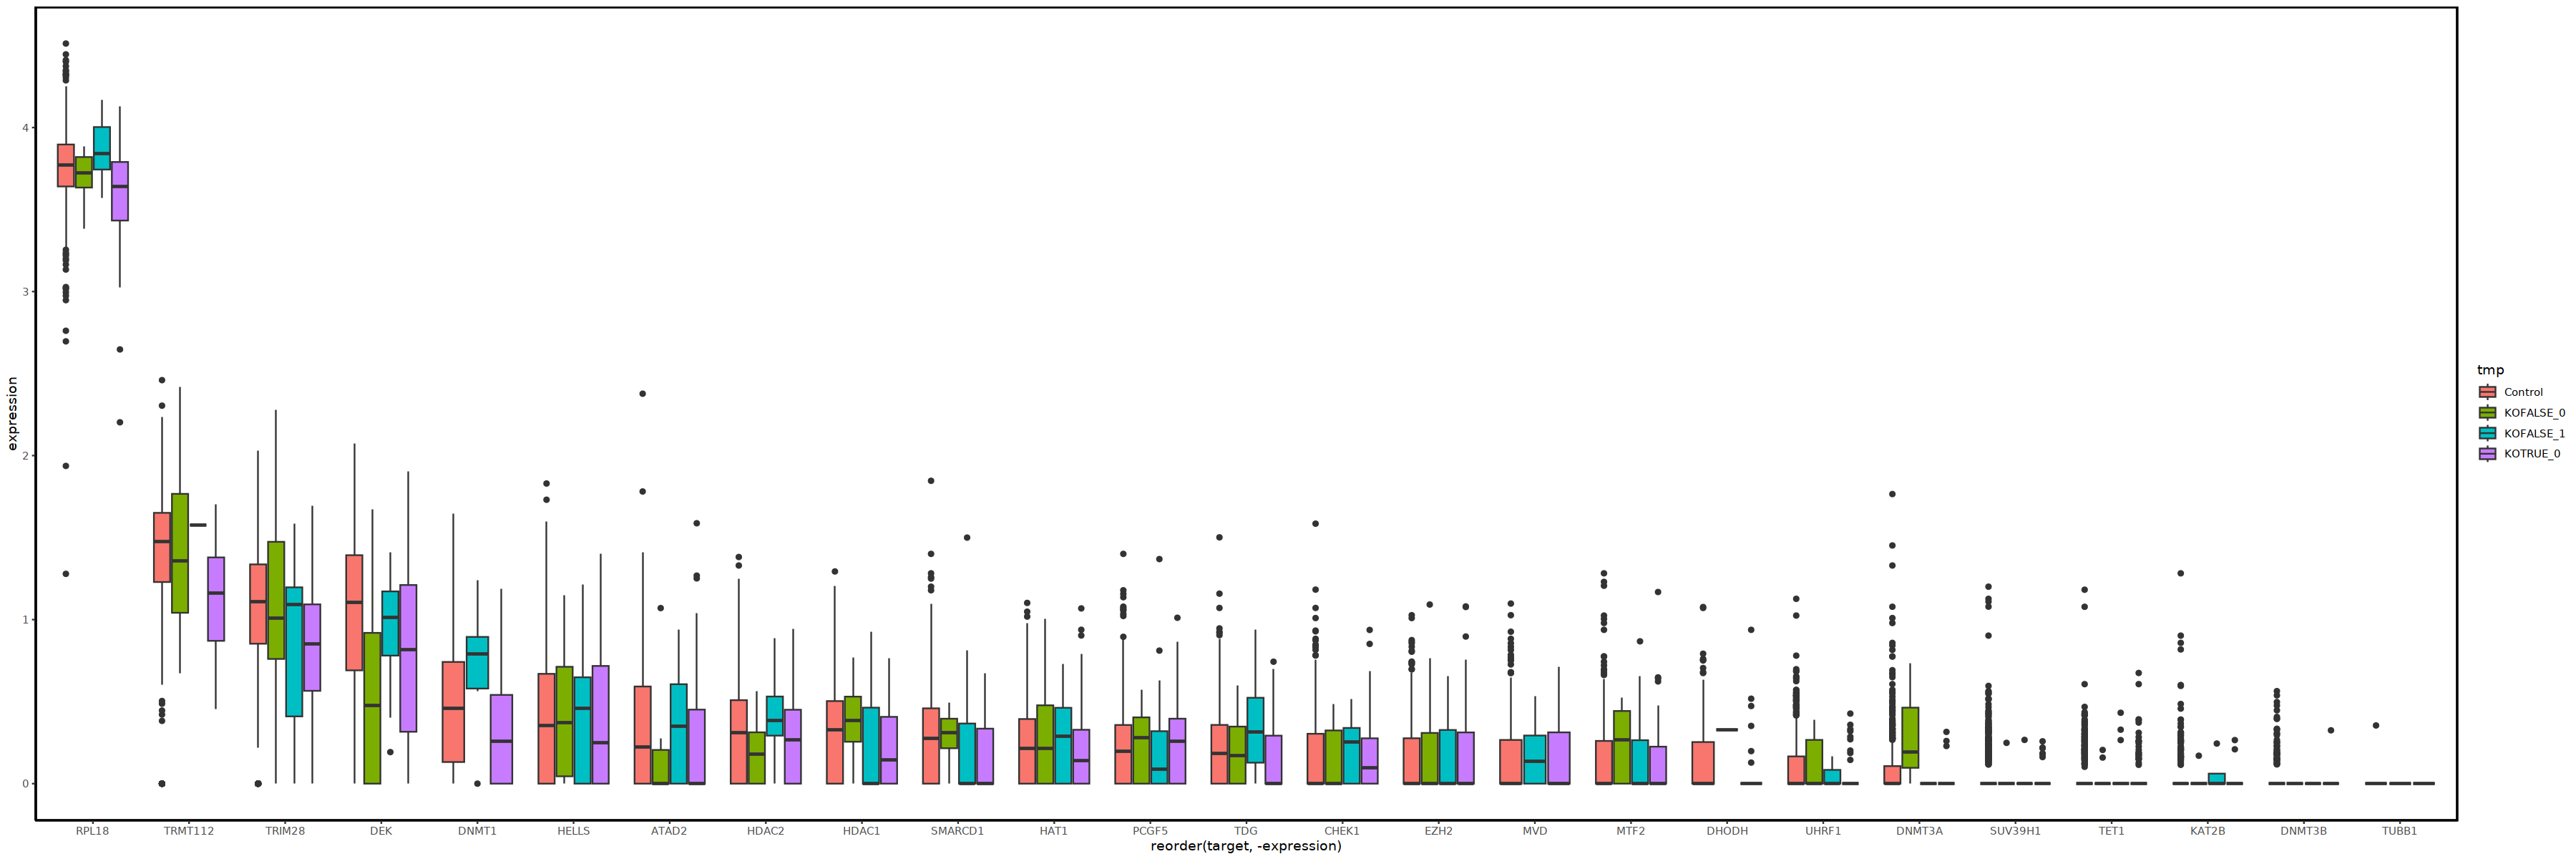

In [108]:
options(repr.plot.width=30,repr.plot.height=10)
ggplot(all.exp2.MT.df, aes(x = reorder(target, -expression), y = expression, fill = tmp)) + 
geom_boxplot()+theme_classic()+theme( panel.border =element_rect(colour = 'black', fill = NA, size = 1))
